***Value Investor***

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.



Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectivenes

PIPLELINE : 

Data extraction --> Data split and visualization --> Preprocessing --> Train model --> model tuning --> Feature extraction

In [1]:
!pip install pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00


In [2]:
#importing useful libraries/modules for this project

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as mpl
import math
import os, glob
from matplotlib import style

#decomposition and kpss from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler


mpl.rcParams['figure.figsize'] = (16,12)
style.use('ggplot')
np.warnings.filterwarnings('ignore')


In [3]:
#load data 
from google.colab import files
 
 
uploaded = files.upload()

Saving project5.xlsx to project5.xlsx


In [4]:
df_f = pd.read_excel('project5.xlsx', 
                       sheet_name = None, 
                       parse_dates=['Date'], 
                       index_col = 'Date', 
                       skipfooter=1)

In [5]:
#Breakdown pages in excel sheet
print(f'Excel spreadsheet has {len(df_f.keys())} sheets')

Excel spreadsheet has 8 sheets


In [6]:
#select first page as a reference
#print the name of first page
print(f'First sheet is : {list(df_f.keys())[0]}')
df1 = df_f[list(df_f.keys())[0]]
df2 = df_f[list(df_f.keys())[1]]
df3 = df_f[list(df_f.keys())[2]]
df4 = df_f[list(df_f.keys())[3]]
df5 = df_f[list(df_f.keys())[4]]
df6 = df_f[list(df_f.keys())[5]]
df7 = df_f[list(df_f.keys())[6]]
df8 = df_f[list(df_f.keys())[7]]
df1.head(), df1.tail()

First sheet is : Russia - Sberbank Rossii PAO (S


(             Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2021-03-31  291.02  294.00  294.42  290.26  47.00M   -0.0076
 2021-03-30  293.25  294.86  295.72  291.50  38.81M   -0.0002
 2021-03-29  293.30  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25  286.66  286.50  287.03  283.85  35.22M    0.0030,
              Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
 2020-01-03  255.00  255.99  258.19  253.70  35.85M    0.0010)

In [7]:
df1.shape, df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.0+ KB


((311, 6), None)

PREPROCESSING

In [8]:
#there are different objects in spreadsheet such as M ( million) and K ( kilo) and we need to transfer it to digit/float
def convert_volume(v):
    if v[-1]=='M':
        return float(v[:-1])*1000000
    elif v[-1]=='K':
        return float(v[:-1])*1000
    else:
        return 0

now converting % sign to x100 to remove any object

Data analysis visual

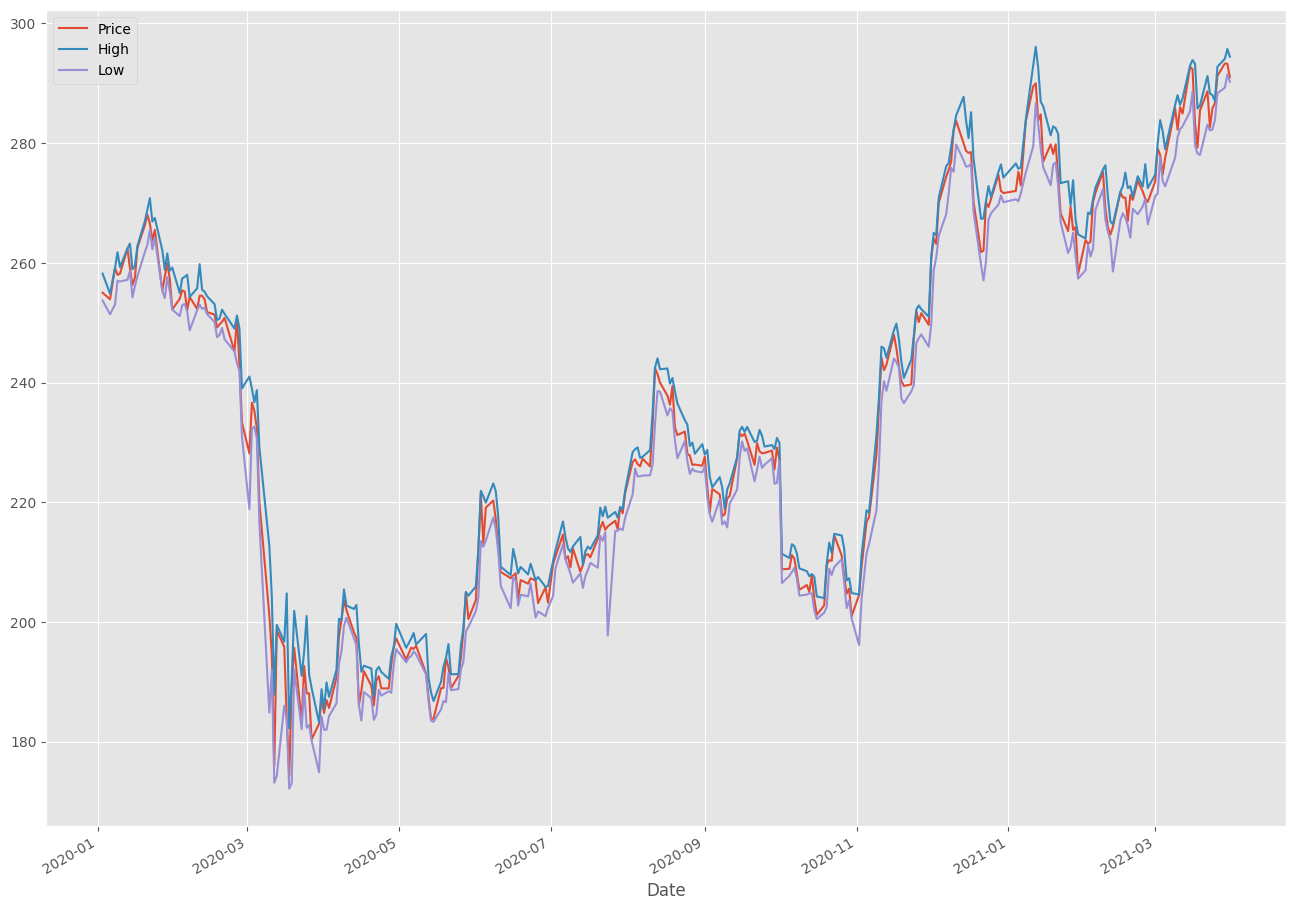

In [9]:
df1[['Price','High', 'Low']].plot()
mpl.show()

Based on presented graph, the price vs time series has no stationarity nor seasionality 

Decomposition can be used to check that


<Axes: xlabel='Date'>

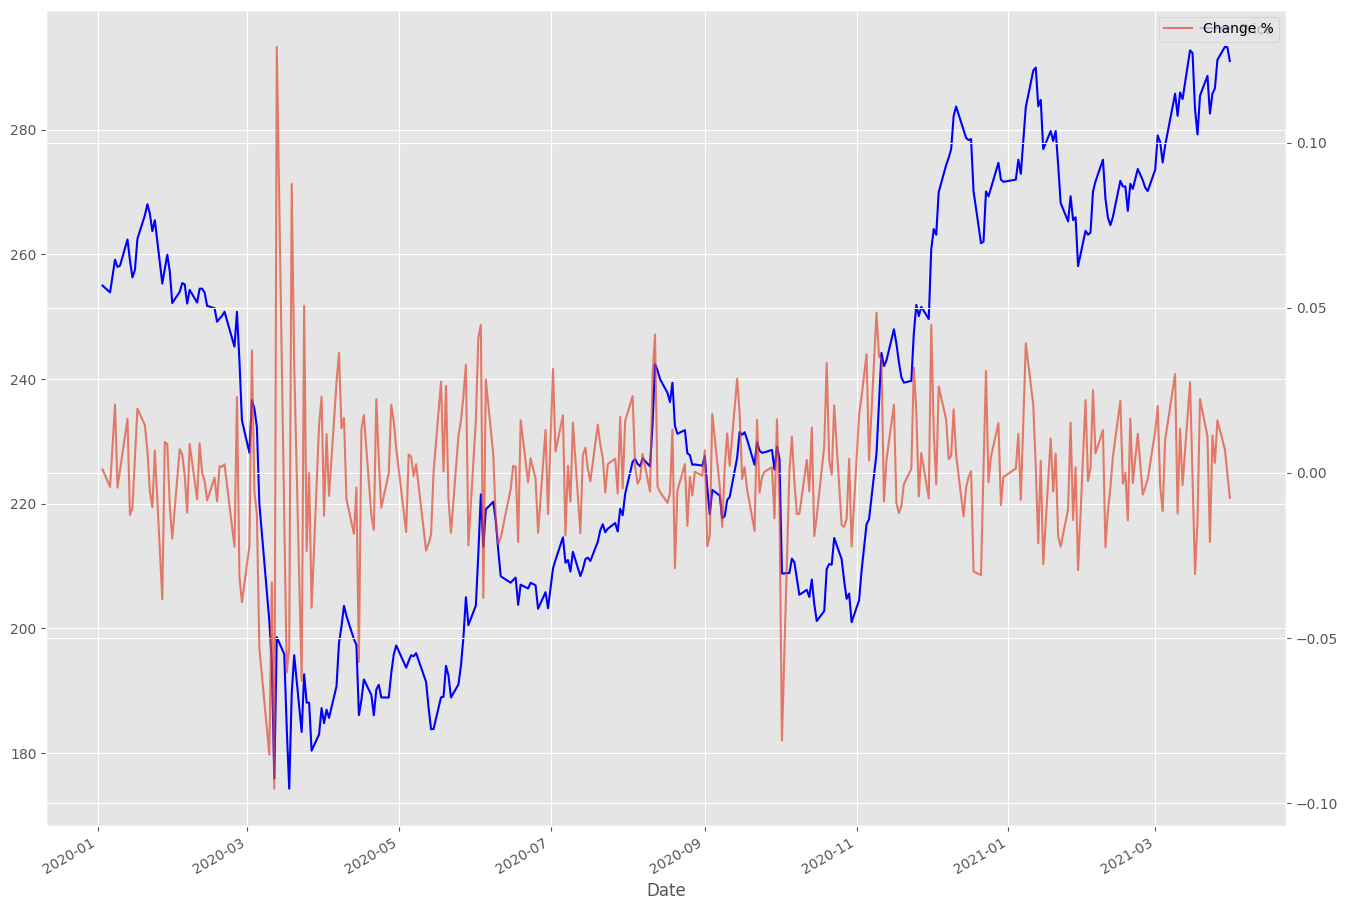

In [10]:
fig, ax1 = mpl.subplots()
df1['Price'].plot(ax = ax1, color = 'blue', legend = 'Price')

ax2 = ax1.twinx()
df1['Change %'].plot(ax = ax2, alpha = 0.7, legend = " Change %")

Since all stocks are plot in one chart, we can look if there is any common trend among them. 

As they different prices, we can upscale them using max-min scaler function


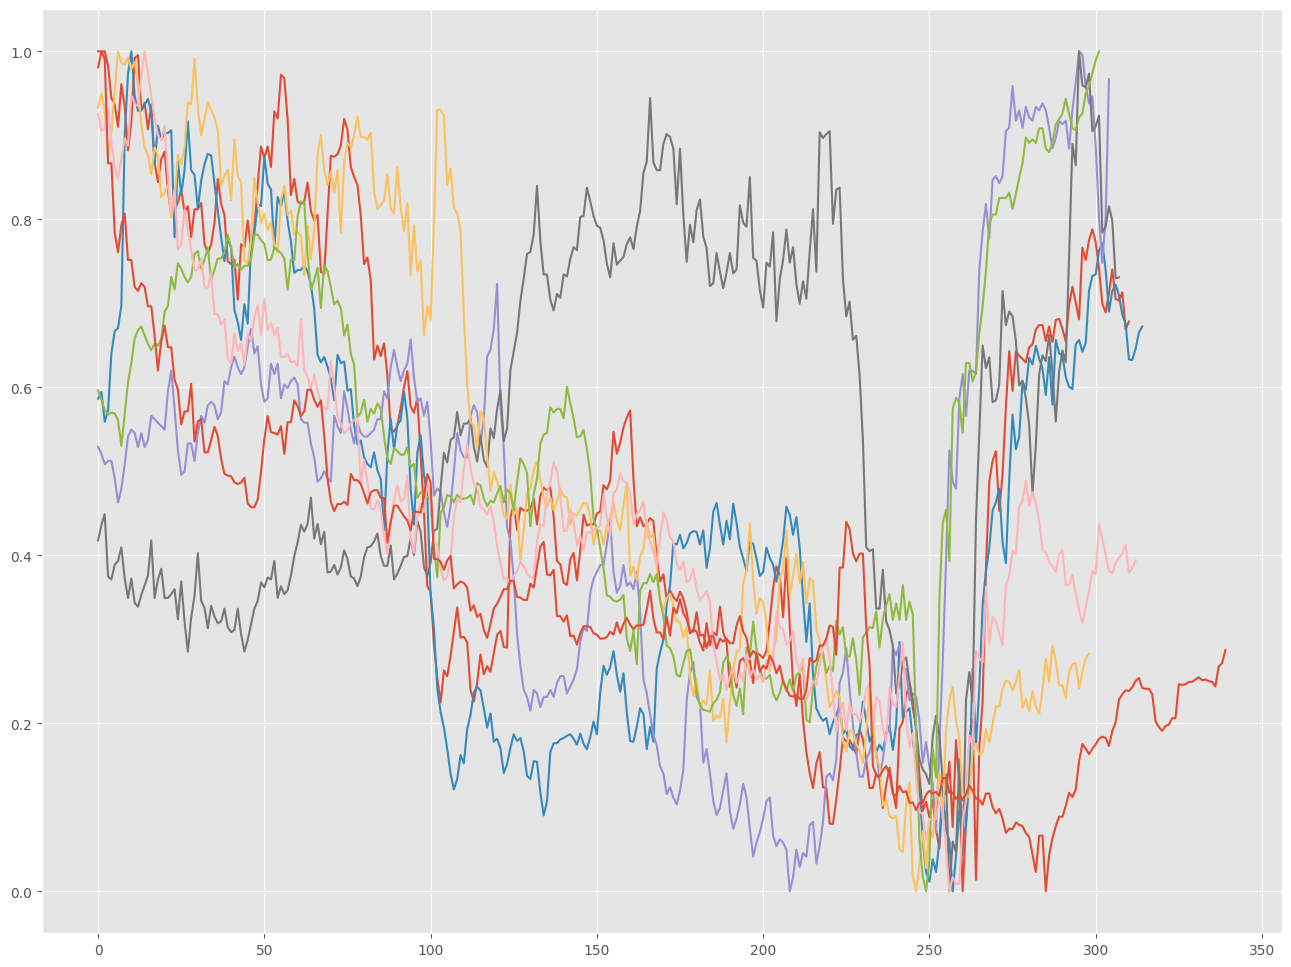

In [11]:
for k in df_f.keys():
  scaler = MinMaxScaler()
  y_t = scaler.fit_transform(np.array(df_f[k][['Price']]))
  mpl.plot(y_t)

mpl.show()

conclusion :

There is no common trend among them.

additionally, some of them drop after march 2020 when pandemic started  while some increased a lot


***Selected dataset : Sberbank Rossii PAO (s)***

# Decomposition

This section allows to check if there is any seasonal fluctuation in time series ( seasionality)

It breaks down to 3 categories :
1. Trend : Overall direction where data is travelling

2. Seasionality : cycle pattern of data

3. Noise : random varies

If dataset can be decomposed, hence it should have a defined frequency. The dataset does not have any frequency however we can introduce it


In [12]:
print(df1.index.freq)

None


The selected frequency is 'B' which is business days. Since we are not omitting, the holidays, then we can use business days to get the closest to the dataset

In [13]:
#reSampling with B and call it dfB

dfB = df1.resample('B').mean()
print(dfB.isna().sum())

Price       14
Open        14
High        14
Low         14
Change %    14
dtype: int64


14 new row added. The values are assigned as NAN using foward filled method, as in stock the price of added day is equal to precious day

However the values for "change % " and "Vol." should be float

which needs to be assigned to 0


In [14]:
dfB.head()

Price    Open    High     Low  Change %
Date                                                
2020-01-03  255.00  255.99  258.19  253.70    0.0010
2020-01-06  253.90  254.75  254.84  251.40   -0.0043
2020-01-07     NaN     NaN     NaN     NaN       NaN
2020-01-08  259.15  253.57  259.15  253.03    0.0207
2020-01-09  257.99  259.40  261.76  257.01   -0.0045

In [15]:
dfB.fillna(method = 'ffill', inplace = True)

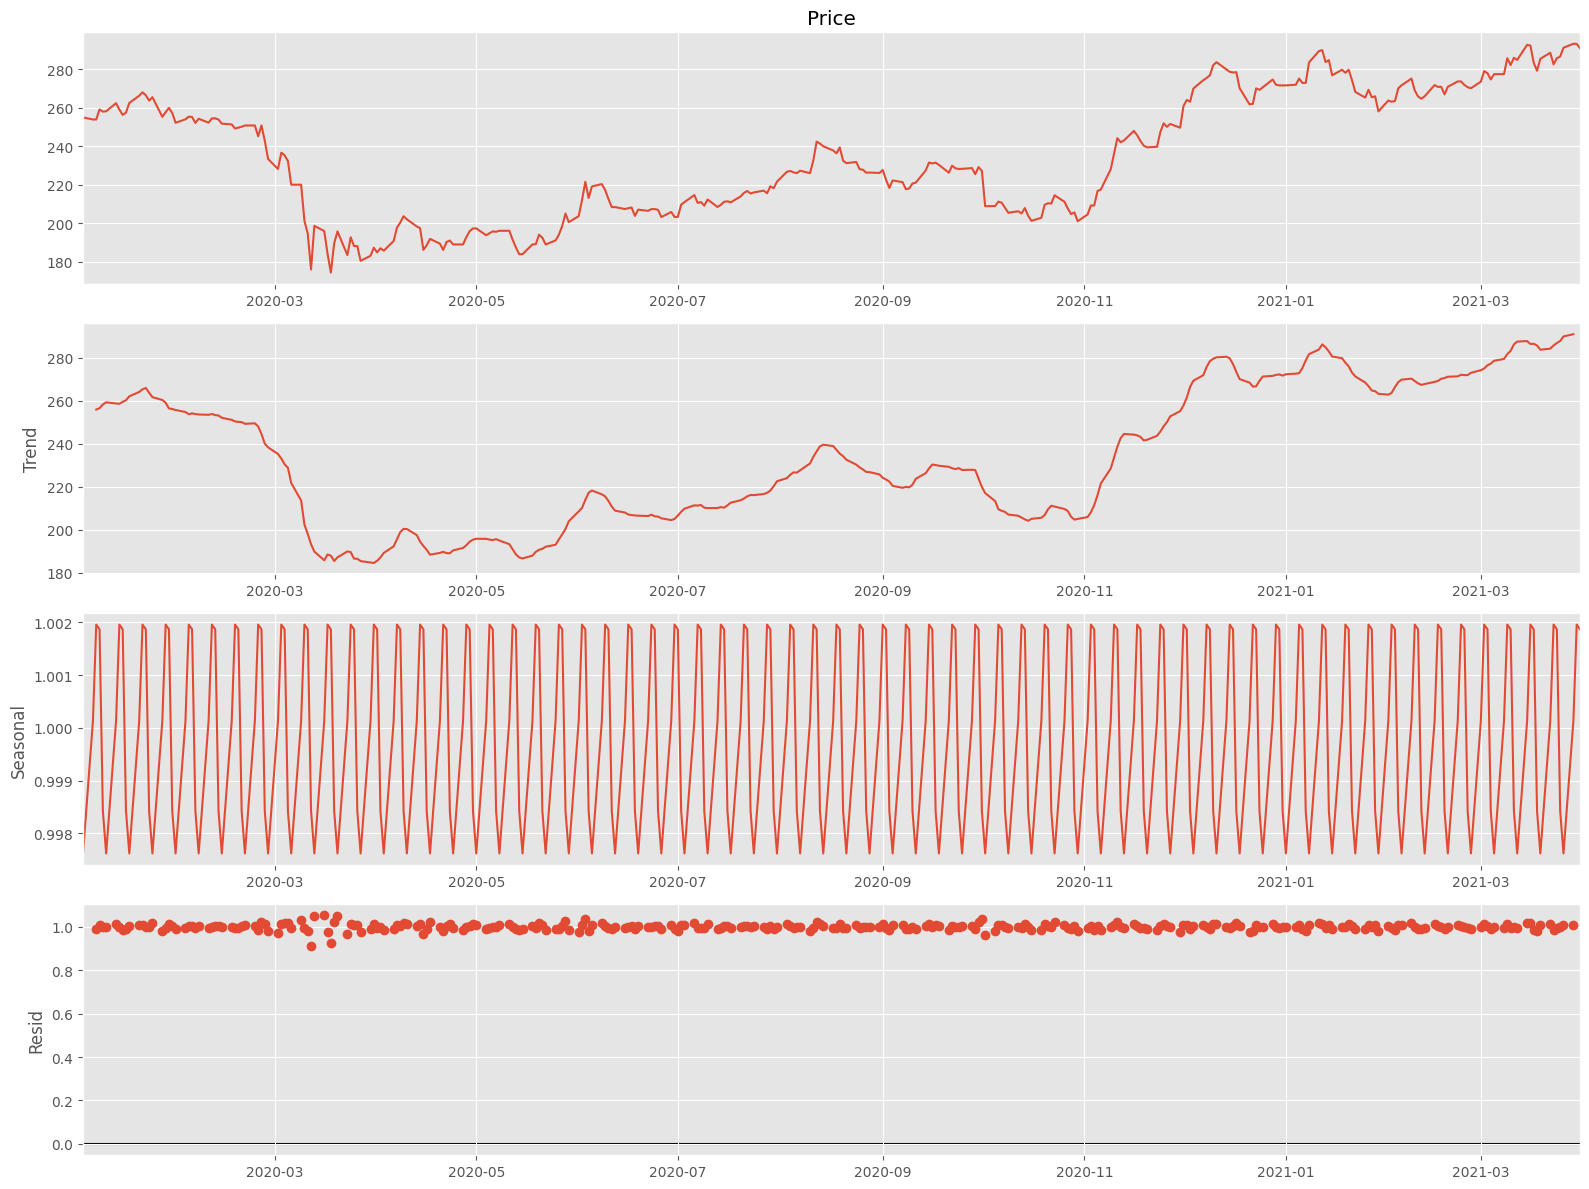

In [16]:
decom = seasonal_decompose(dfB['Price'], model = 'multiplicative')
decom.plot()
mpl.show()

Seasonal_decomposed function in statsmodels used to quantify the component part in dataset.

multiplicative model selected as there is a flunctuation in certain percentage of price in stock( not in fixed one)

we are mainly focusing on "price" column as we can train model with that dataset

# SARIMAX ARIMA


We want to apply ARIMA model however initially we need to check for stationatiy. Time series datasets are stationity if its statiscial features does not change over time. ( mean, variance and converaince needs to be consistent in a time period)

Based on above graphs, the mean is not constant. To check we can use KPSS 

Hypothesis : model is in stationary mode if p-value is less than significance level ( 0.05 is the common one), we reject the null and consider data is NON-stationary

In [17]:
#assign price column as a variable 

C1 = df1['Price']

In [18]:
def get_kpss_stat(C1) :
  kpss_result = kpss(C1)

  print(f'KPSS statistic: {kpss_result[0]}')
  print(f'p-value: {kpss_result[1]}')
  print(f'# lags : {kpss_result[2]}')

get_kpss_stat(C1)

KPSS statistic: 1.248468852376087
p-value: 0.01
# lags : 11


In this case, p-value is less than 0.05, hence null hypothesis rejecteded and model is non-stationary

Now we need to make mean constant to make it stationary

We can do it by differentiating the dataset. To do so, we need to create a new time series comprising the difference b/w the value in original dataset

diff() function is useful, 

<Axes: xlabel='Date'>

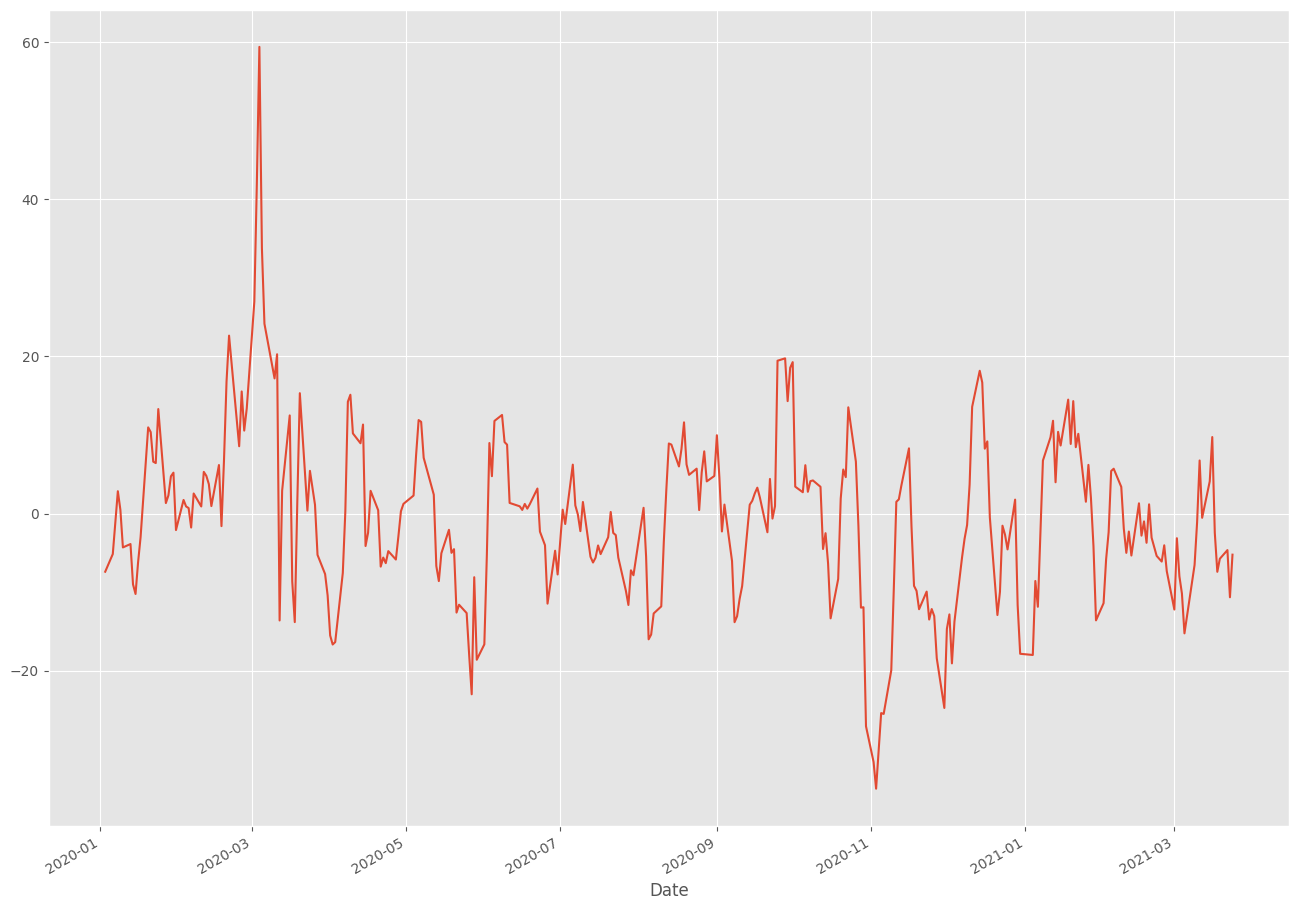

In [19]:
C_d1 = C1.diff(5).dropna()
C_d1.plot()

In [20]:
#check p-value again
get_kpss_stat(C_d1)

KPSS statistic: 0.35328499779642797
p-value: 0.09729094922567759
# lags : 9


Now the p-value increased and goes higher thank 0.05 hence it is stationary.

# DATA SPLIT


As question asked us to split data non-random, hence I break it down

2020 data --> training

2021 data --> test 

In [21]:
test_len = (C1.index.year==2021).sum()
C_train1 = C1[test_len:]
C_test1 = C1[:test_len]


test_len_d = (C_d1.index.year==2021).sum()
C_d_train1 = C_d1[test_len_d:]
C_d_test1 = C_d1[:test_len_d]

In [ ]:
C_d_train1

Date
2020-12-30   -17.84
2020-12-29   -11.64
2020-12-28     1.77
2020-12-25    -4.56
2020-12-24    -2.68
              ...  
2020-01-10    -4.31
2020-01-09     0.48
2020-01-08     2.84
2020-01-06    -5.15
2020-01-03    -7.40
Name: Price, Length: 250, dtype: float64

In [ ]:
C_d_test1

Date
2021-03-24    -5.23
2021-03-23   -10.65
2021-03-22    -4.65
2021-03-19    -5.75
2021-03-18    -7.41
2021-03-17    -2.44
2021-03-16     9.73
2021-03-15     4.09
2021-03-12    -0.54
2021-03-11     6.75
2021-03-10    -1.11
2021-03-09    -6.54
2021-03-05   -15.24
2021-03-04   -10.18
2021-03-03    -7.99
2021-03-02    -3.14
2021-03-01   -12.21
2021-02-26    -7.33
2021-02-25    -4.04
2021-02-24    -6.11
2021-02-22    -5.39
2021-02-20    -3.07
2021-02-19     1.17
2021-02-18    -3.72
2021-02-17    -1.00
2021-02-16    -2.81
2021-02-15     1.30
2021-02-12    -5.34
2021-02-11    -2.29
2021-02-10    -5.00
2021-02-09    -1.92
2021-02-08     3.39
2021-02-05     5.70
2021-02-04     5.41
2021-02-03    -2.37
2021-02-02    -5.83
2021-02-01   -11.40
2021-01-29   -13.59
2021-01-28    -4.15
2021-01-27     1.97
2021-01-26     6.19
2021-01-25     1.50
2021-01-22    10.14
2021-01-21     8.44
2021-01-20    14.30
2021-01-19     8.85
2021-01-18    14.49
2021-01-15     8.65
2021-01-14    10.39
2021-01-13     

For applying SARIMAX model, we need, p, d and q parameter. To evaluate these parameters y_diff needs to be feed to ARIMA model amd calculate their RMS.

In [22]:
pdq_ARIMA = auto_arima(C_d_train1, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1656.707, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.915, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1675.911, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1675.909, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.924, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1675.590, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1677.563, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1623.473, Time=1.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1674.681, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1642.842, Time=0

In [23]:
total_len1 = C1.shape[0]
train_len1 = (C1.index.year==2020).sum()
model = SARIMAX(C_train1, order = (p,d+1,q), seasonal_order= (p,d+1,q,10))
model = model.fit()
C_pred1 = model.predict(start = train_len1, end = total_len1-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  250
Model:             SARIMAX(4, 2, 5)x(4, 2, 5, 10)   Log Likelihood                -732.554
Date:                            Thu, 30 Mar 2023   AIC                           1503.107
Time:                                    00:06:35   BIC                           1568.265
Sample:                                         0   HQIC                          1529.396
                                            - 250                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1491      0.291     -7.390      0.000      -2.719      -1.579
ar.L2         -2.3242      0.636     -3.656      0.000      -3.570      -1.078
ar.L3         -1.3865      0.605     -2.291      0.022      -2.573      -0.200
ar.L4         -0.4470      0.262     -1.707      0.088      -0.960       0.066
ma.L1          1.1595      0.318      3.644      0.000       0.536       1.783
ma.L2          0.1034      0.455      0.227      0.820      -0.788       0.995
ma.L3         -1.0611      0.255     -4.154      0.000      -1.562      -0.560
ma.L4         -0.8763      0.433     -2.024      0.043      -1.725      -0.028
ma.L5         -0.2803      0.315     -0.890      0.373      -0.897       0.337
ar.S.L10      -1.5803      0.295     -5.363      0.000      -2.158      -1.003
ar.S.L20      -1.6005      0.397     -4.036      0.000      -2.378      -0.823
ar.S.L30      -1.1725      0.337     -3.478      0.001      -1.833      -0.512
ar.S.L40      -0.2497      0.139     -1.794      0.073      -0.523       0.023
ma.S.L10      -0.3695      0.866     -0.427      0.670      -2.067       1.328
ma.S.L20      -0.4307      0.903     -0.477      0.633      -2.200       1.339
ma.S.L30      -0.3910      0.667     -0.586      0.558      -1.699       0.917
ma.S.L40      -0.5169      0.919     -0.563      0.574      -2.317       1.284
ma.S.L50       0.7682      0.610      1.260      0.208      -0.427       1.963
sigma2        23.7419     12.620      1.881      0.060      -0.993      48.476
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                26.45
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
C_train1

Date
2020-12-30    271.65
2020-12-29    272.00
2020-12-28    274.70
2020-12-25    270.64
2020-12-24    269.32
               ...  
2020-01-10    258.19
2020-01-09    257.99
2020-01-08    259.15
2020-01-06    253.90
2020-01-03    255.00
Name: Price, Length: 250, dtype: float64

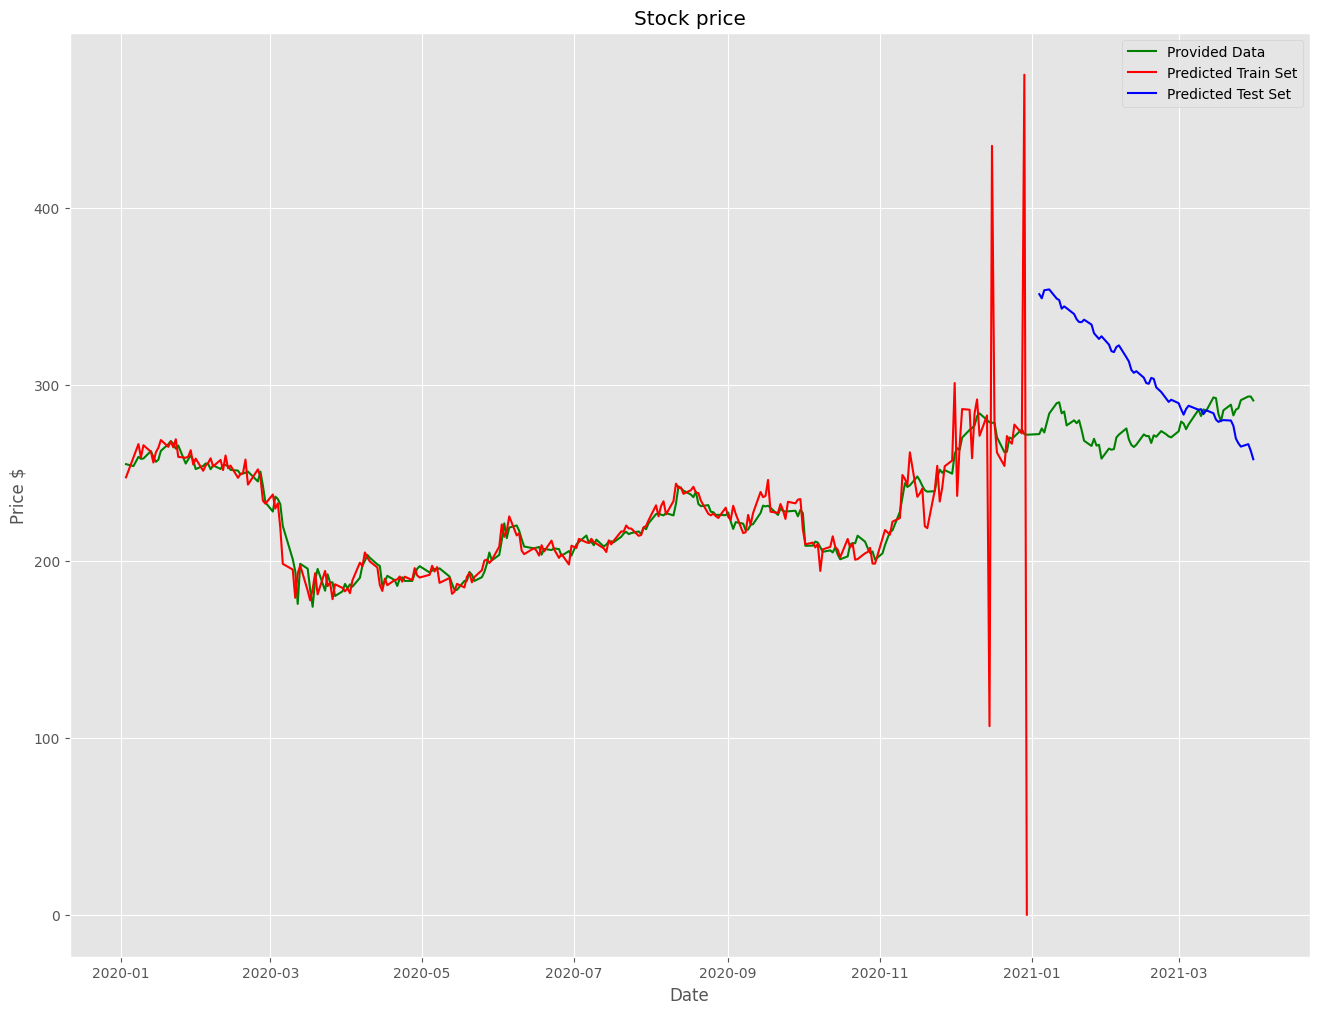

In [24]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C1, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred1.index = C_test1.index
mpl.plot(C_pred1, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

# BOLLINGER BANDS

Bollinger bands is a popular method among stock trading. It consist 3 lines ⁉

1. price moveing avg for selected window
2. Upper bollinger band
3. lower bollinger band

using given function to this model

In [25]:
def bollinger_bands(df, n):
    # takes dataframe on input
    # n = smoothing length
    
    df['mov_avg'] = df['predicted'].rolling(n).mean()
    df['mov_std'] = df['predicted'].rolling(n).std()
    df['upper'] = df['mov_avg'] + 2*df['mov_std']
    df['lower'] = df['mov_avg'] - 2*df['mov_std']
    df.dropna(inplace = True)
    return df

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

def plot_bollinger(df, buy_price, sell_price):
    df['predicted'].plot(label = 'Predicted Price', alpha = 0.3, color = 'blue')
    df['test_set'].plot(label = 'Actual Price', alpha = 0.3, color = 'red')
    df['upper'].plot(label = 'Upper BB', linestyle = '--', linewidth = 1, color = 'black')
    df['mov_avg'].plot(label = 'Middle BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['lower'].plot(label = 'Lower BB', linestyle = '--', linewidth = 1, color = 'black')
    mpl.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    mpl.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    mpl.title('Bollinger Band Strategy Trading Signals')
    mpl.legend(loc = 'upper left')
    mpl.show()

    
def calculate_return(buy_price, sell_price, y_test):
    i = 0
    result =0
    bp = None
    initial = None
    while i < len(buy_price) and math.isnan(buy_price[i]):
        i+=1
    if i < len(buy_price) and buy_price[i]>0:
        initial = buy_price[i]
    while i < len(buy_price):
        if buy_price[i]>0:
            bp = buy_price[i]
        elif sell_price[i]>0:
            if bp:
                result += (sell_price[i]-bp)
                bp = None
        i+=1
    if initial:
        result = (result/initial)*100
    do_nothing = (y_test[-1]/y_test[0] -1)*100
    print(f'Return using Bollinger Band Strategy is {round(result,2)}%.\nReturn from do nothing strategy is {round(do_nothing,2)}%')

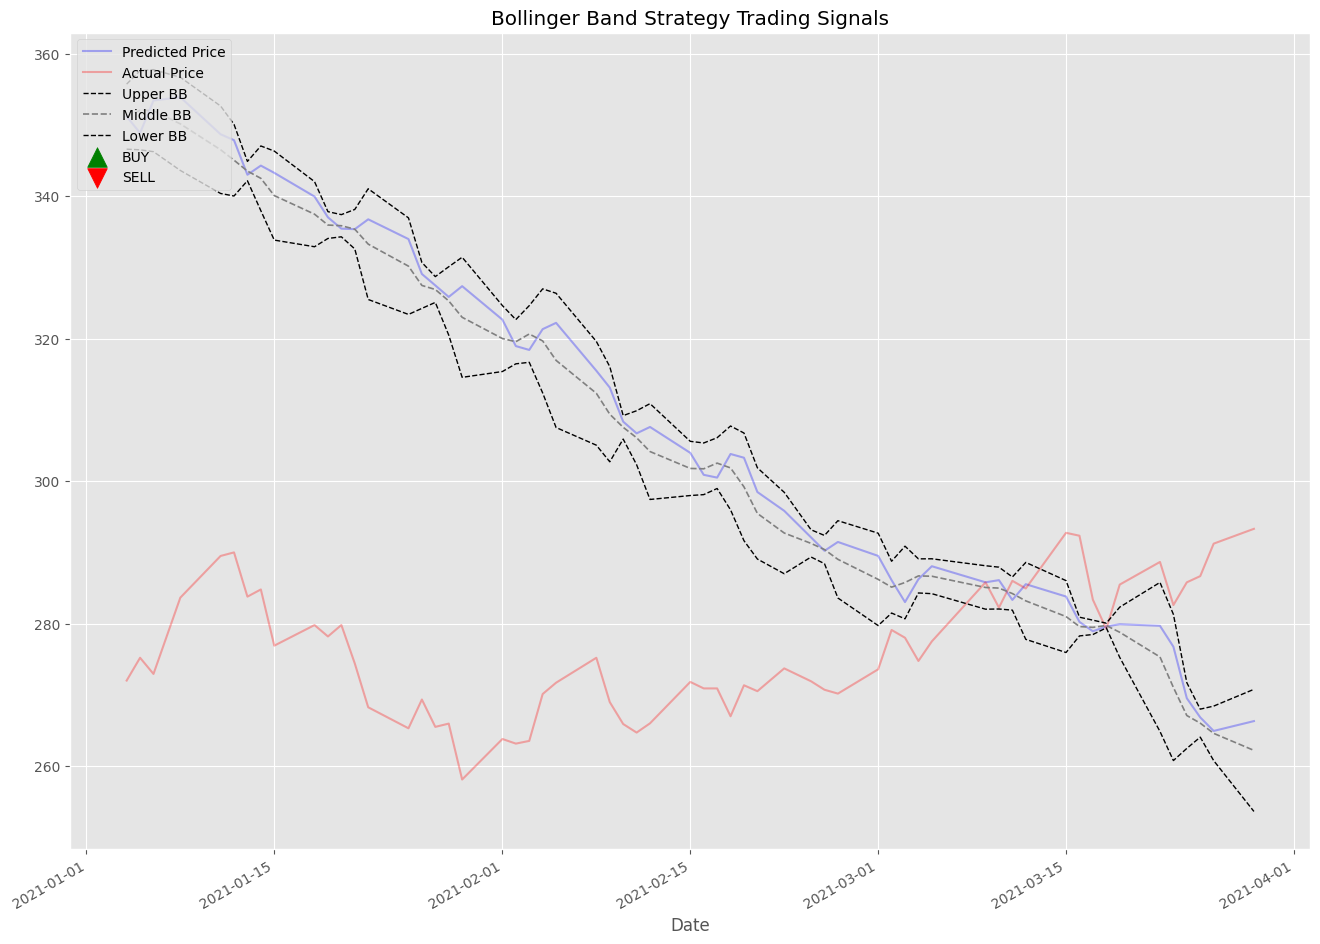

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -6.54%


In [26]:
#graph

df_pred = pd.DataFrame({'test_set':C_test1, 'predicted':C_pred1})
df_pred = bollinger_bands(df_pred, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test1)

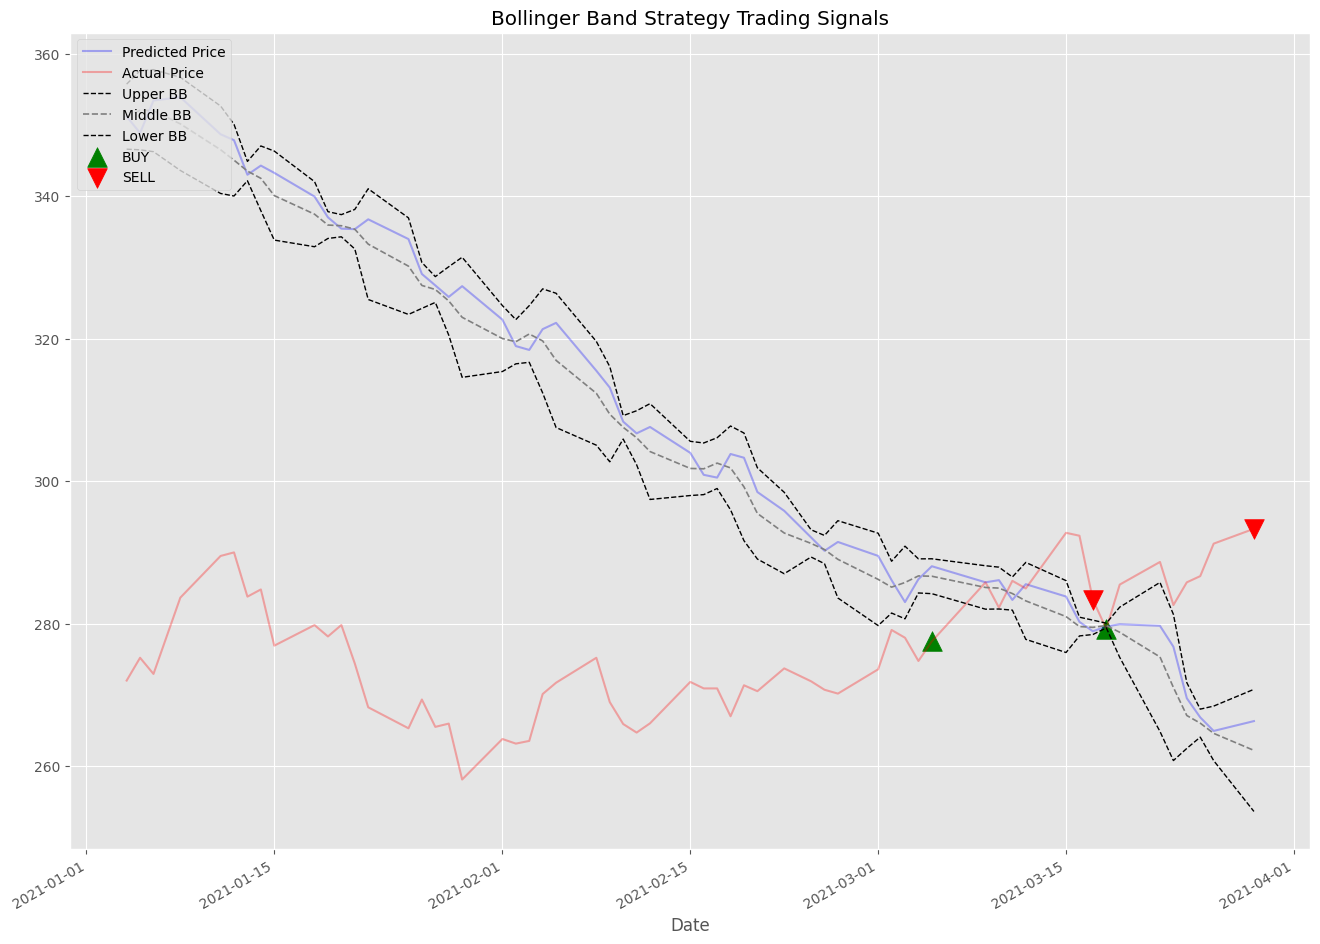

Return using Bollinger Band Strategy is 1.47%.
Return from do nothing strategy is -6.54%


In [27]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test1)

#Koc Holding AS



Turkey - Koc Holding AS (KCHOL)


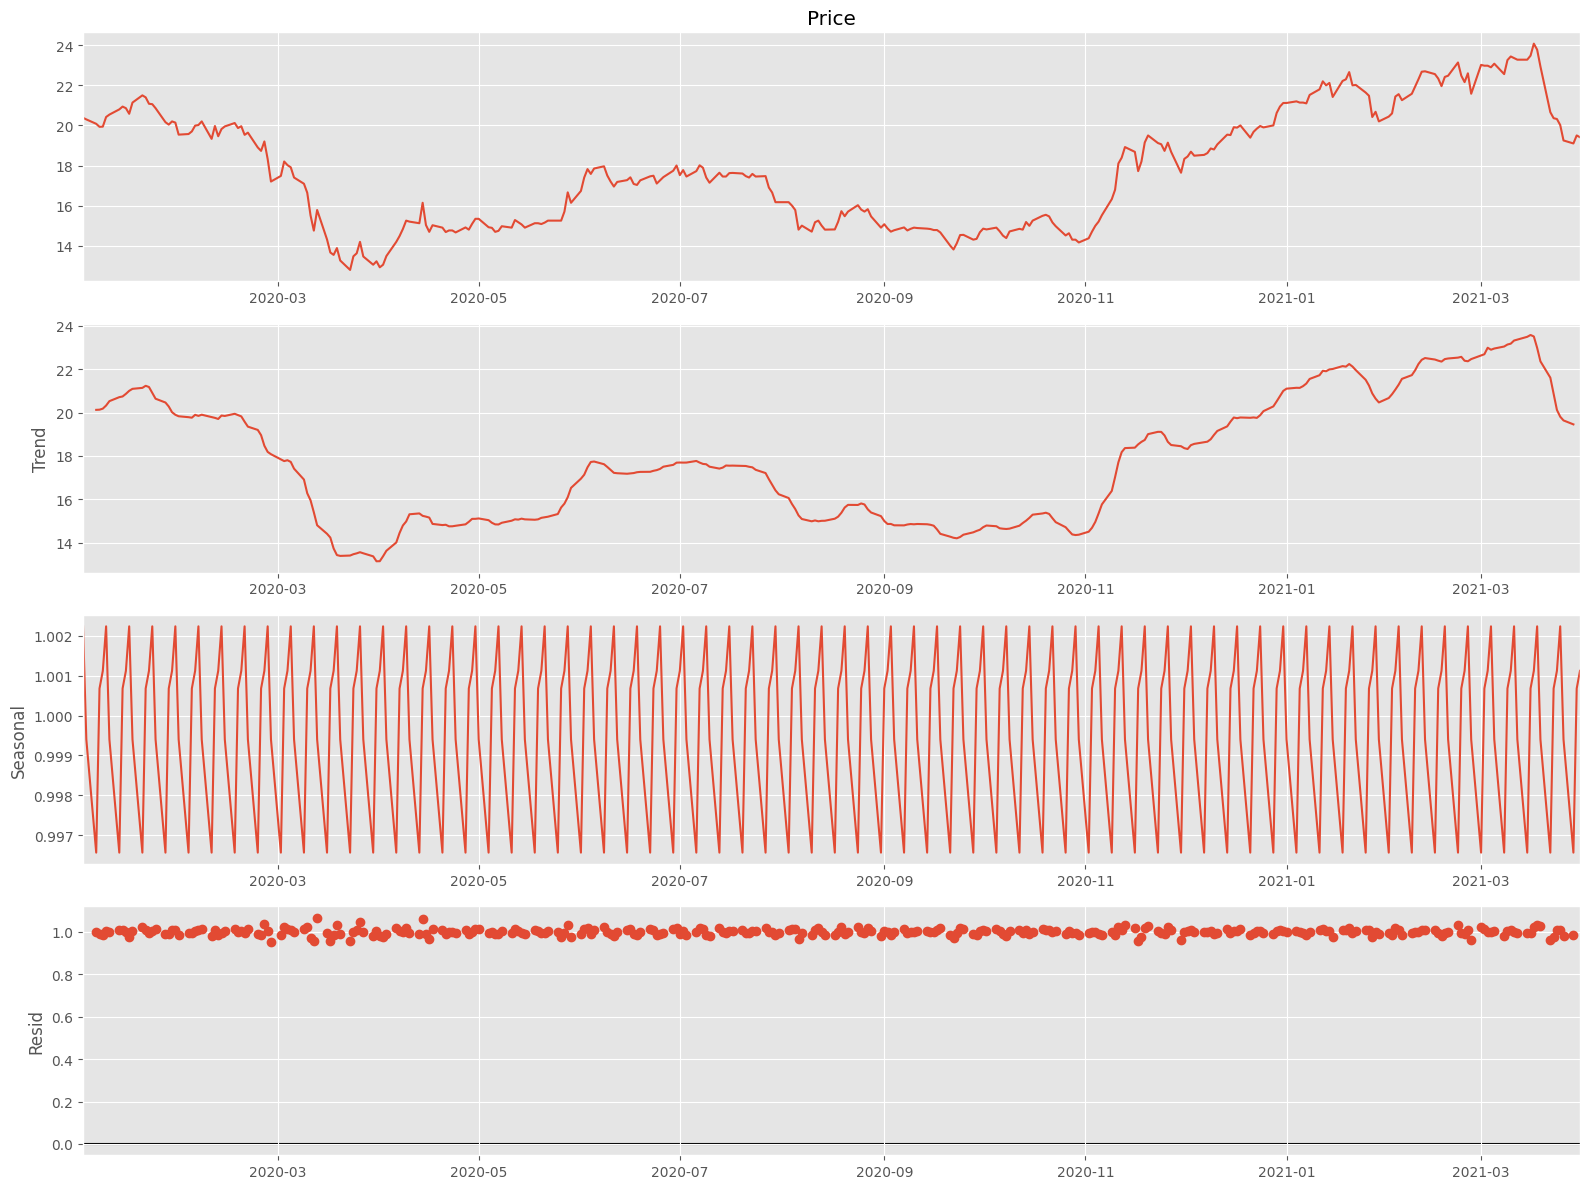

KPSS statistic: 0.8954433530037161
p-value: 0.01
# lags : 11
KPSS statistic: 0.19103534246220247
p-value: 0.1
# lags : 10


In [28]:
from scipy.signal import cheb2ord
company = list(df_f.keys())[1]
print(company)
df2 = df_f[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df2 = df2.resample('B').mean()
df2.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df2['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C2 = df2['Price']
# Check for stationarity
get_kpss_stat(C2)

C_d2 = C2.diff(5).dropna()
get_kpss_stat(C_d2)


In [29]:
train_len2 = (C2.index.year==2020).sum()
C_train2 = C2[:train_len2]
C_test2 = C2[train_len2:]


train_len_d2 = (C_d2.index.year==2020).sum()
C_d_train2 = C_d2[:train_len_d2]
C_d_test2 = C_d2[train_len_d2:]

In [ ]:
C_d_train2

Date
2020-01-09    0.04
2020-01-10    0.24
2020-01-13    0.72
2020-01-14    1.01
2020-01-15    0.92
              ... 
2020-12-25   -0.10
2020-12-28    0.61
2020-12-29    0.94
2020-12-30    1.10
2020-12-31    1.15
Freq: B, Name: Price, Length: 256, dtype: float64

In [30]:
pdq_ARIMA = auto_arima(C_d_train2, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=374.438, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=419.547, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=421.193, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=421.118, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=417.564, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=423.523, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=424.831, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=424.969, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=423.491, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.83

In [31]:
total_len2= C2.shape[0]
train_len2 = (C2.index.year==2020).sum()
model = SARIMAX(C_train2, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred2 = model.predict(start = train_len2, end = total_len2-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 5)   Log Likelihood                -155.407
Date:                           Thu, 30 Mar 2023   AIC                            328.813
Time:                                   00:07:49   BIC                            360.470
Sample:                               01-02-2020   HQIC                           341.556
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9442      6.893     -0.137      0.891     -14.455      12.567
ar.L2          0.0554      0.377      0.147      0.883      -0.684       0.794
ma.L1         -0.0004    3.3e+04  -1.17e-08      1.000   -6.47e+04    6.47e+04
ma.L2         -0.9996    3.3e+04  -3.03e-05      1.000   -6.47e+04    6.47e+04
ar.S.L5       -0.0358      0.084     -0.425      0.671      -0.201       0.129
ar.S.L10      -0.2238      0.070     -3.201      0.001      -0.361      -0.087
ma.S.L5       -1.8531      2.191     -0.846      0.398      -6.147       2.441
ma.S.L10       0.8535      1.852      0.461      0.645      -2.777       4.484
sigma2         0.1587   5240.171   3.03e-05      1.000   -1.03e+04    1.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.87
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               0.55   Skew:                             0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

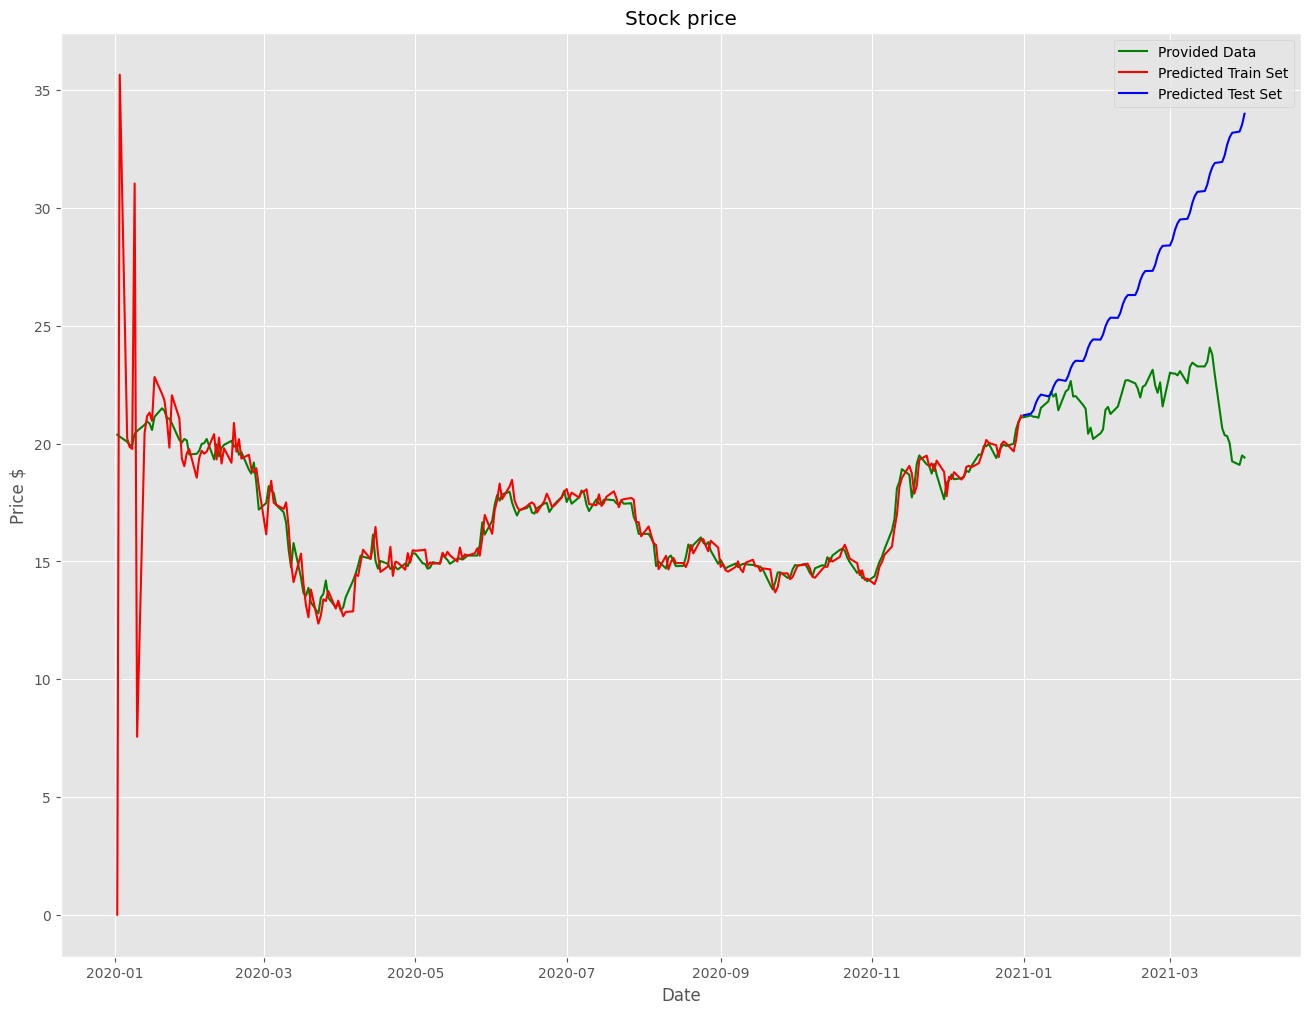

In [32]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C2, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred2.index = C_test2.index
mpl.plot(C_pred2, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

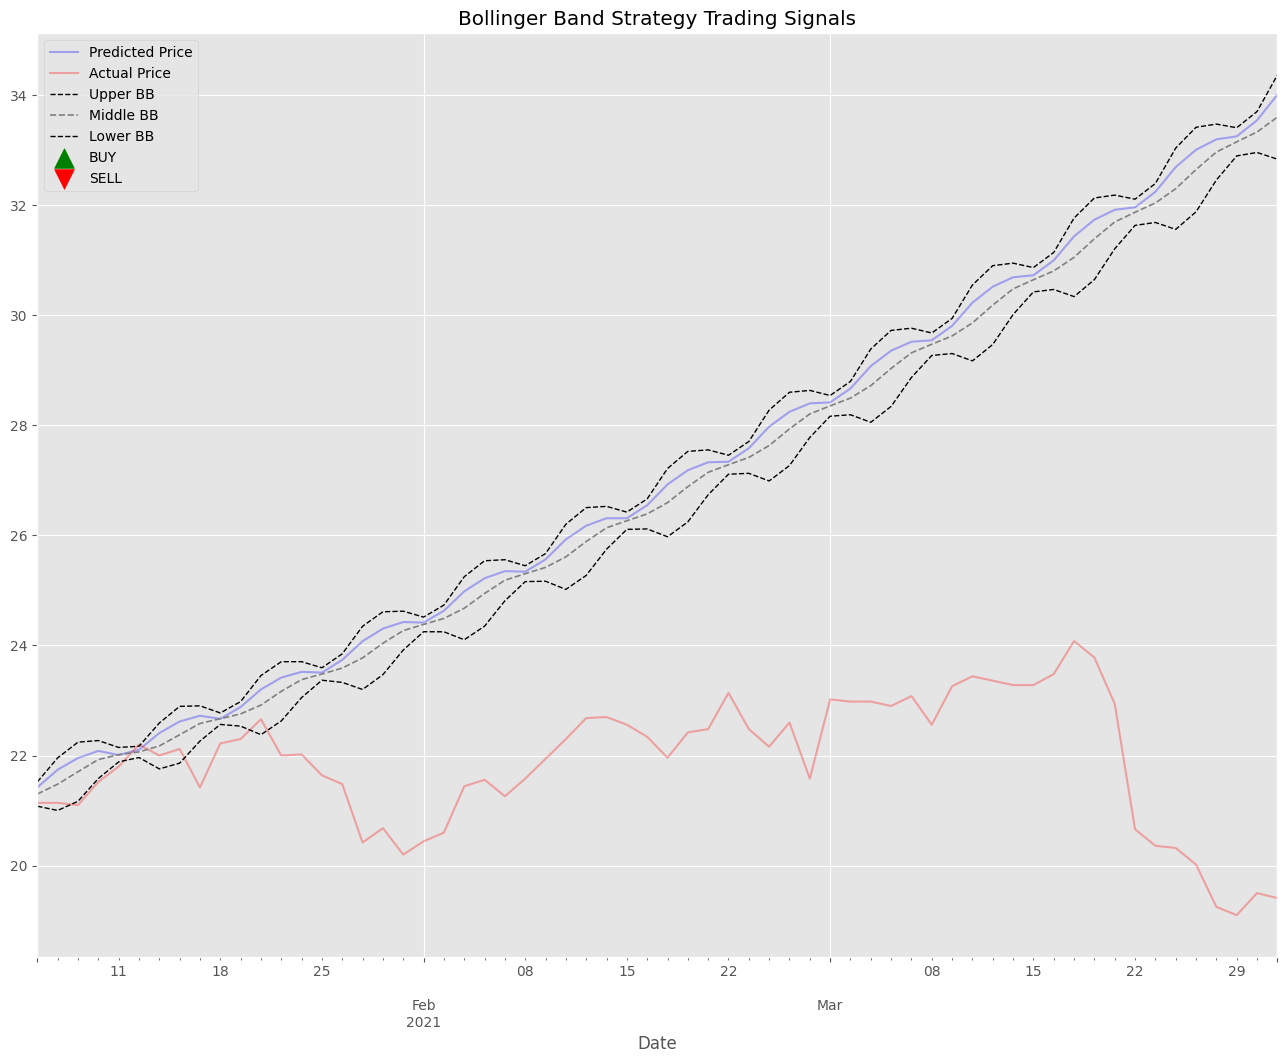

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -8.1%


In [34]:
#graph

df_pred2 = pd.DataFrame({'test_set':C_test2, 'predicted':C_pred2})
df_pred2 = bollinger_bands(df_pred2, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred2['predicted'], df_pred2['lower'], df_pred2['upper'])
plot_bollinger(df_pred2, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test2)

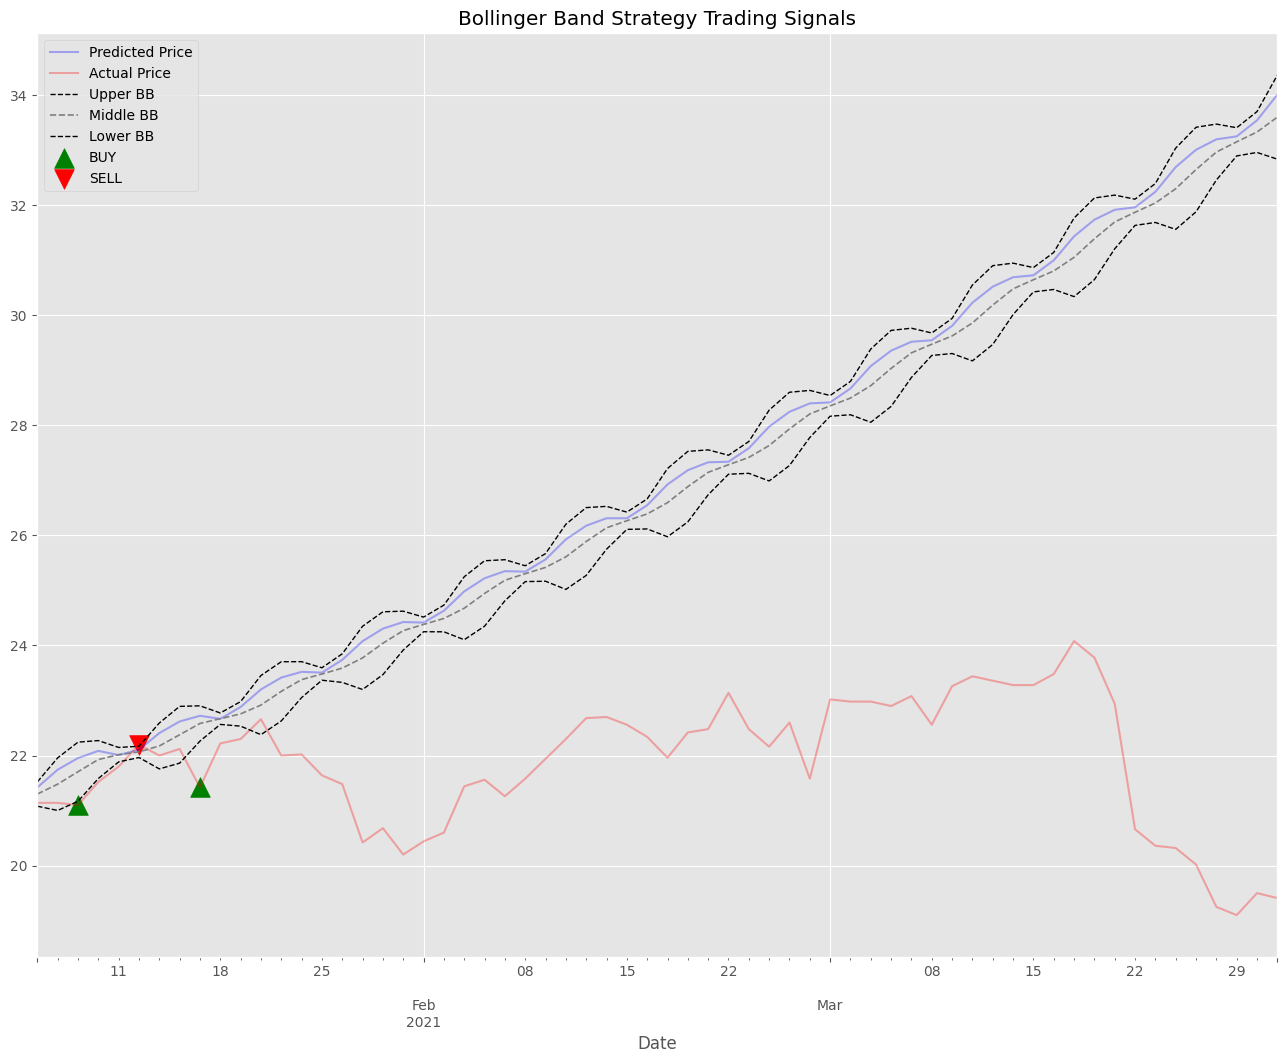

Return using Bollinger Band Strategy is 5.21%.
Return from do nothing strategy is -8.1%


In [35]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred2['test_set'], df_pred2['lower'], df_pred2['upper'])
plot_bollinger(df_pred2, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test2)

#Medinet Nasr Housing (M

Egypt - Medinet Nasr Housing (M


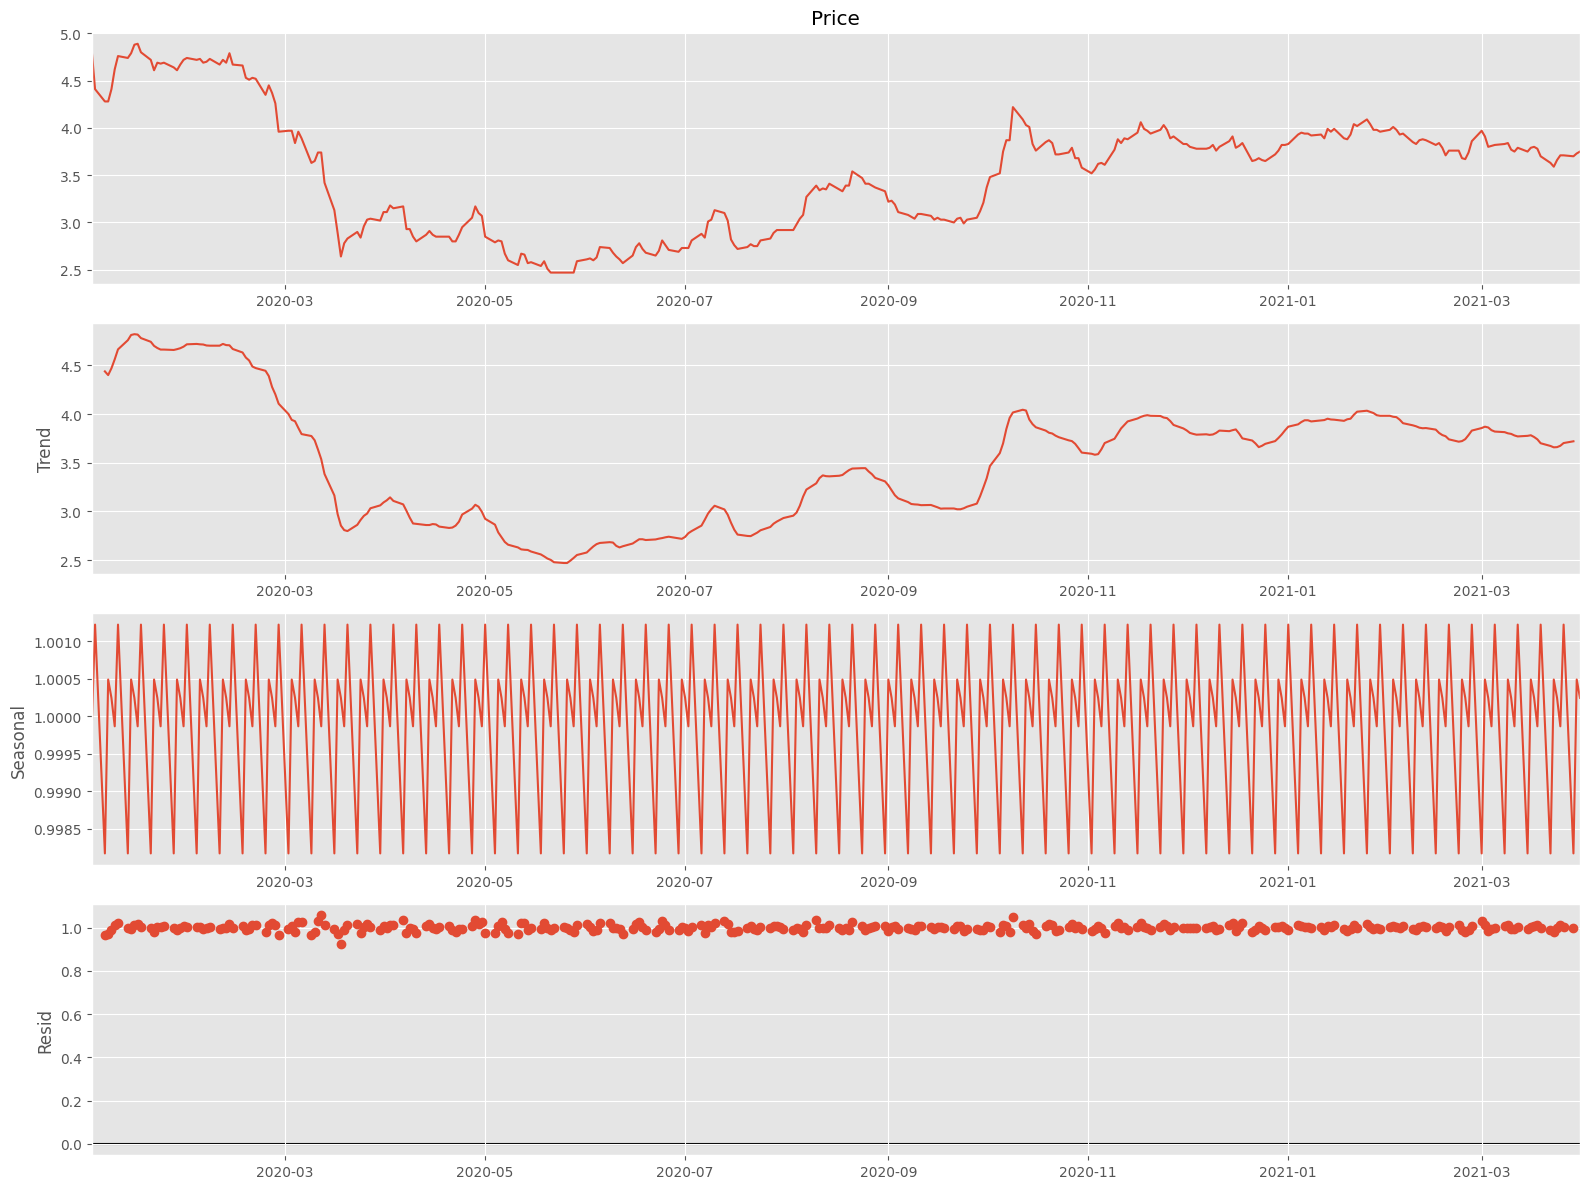

KPSS statistic: 0.4930959740595632
p-value: 0.04322162746406235
# lags : 11
KPSS statistic: 0.2579770647344528
p-value: 0.1
# lags : 10


In [36]:
from pandas.core.arrays.period import c_dt64arr_to_periodarr
company = list(df_f.keys())[2]
print(company)
df3 = df_f[company]

df3 = df3.resample('B').mean()
df3.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df3['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C3 = df3['Price']
# Check for stationarity
get_kpss_stat(C3)

C_d3 = C3.diff(5).dropna()
get_kpss_stat(C_d3)


In [37]:
train_len3 = (C3.index.year==2020).sum()
C_train3 = C3[:train_len3]
C_test3 = C3[train_len3:]


train_len_d3 = (C_d3.index.year==2020).sum()
C_d_train3 = C_d3[:train_len_d3]
C_d_test3 = C_d3[train_len_d3:]

In [38]:
pdq_ARIMA = auto_arima(C_d_train3, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-385.946, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4.220, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-354.682, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-193.663, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5.416, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-366.827, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-377.919, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-410.888, Time=0.98 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-383.753, Time=0.62 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-373.841, Time=0.87 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-398.997, Time=0.80 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-418.637, Time=0.75 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-403.024, Time=0.43 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-497.745, Time=1.10 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   :

In [39]:
total_len3= C3.shape[0]
train_len3 = (C3.index.year==2020).sum()
model = SARIMAX(C_train3, order = (p,d+1,q), seasonal_order= (p,d+1,q,6))
model = model.fit()
C_pred3 = model.predict(start = train_len2, end = total_len2-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  261
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 6)   Log Likelihood                 249.655
Date:                           Thu, 30 Mar 2023   AIC                           -477.311
Time:                                   00:12:47   BIC                           -438.400
Sample:                               01-02-2020   HQIC                          -461.658
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2091      1.554      0.135      0.893      -2.837       3.255
ma.L1          0.0273      1.550      0.018      0.986      -3.011       3.066
ma.L2          0.0676      0.386      0.175      0.861      -0.690       0.825
ma.L3          0.0235      0.188      0.125      0.901      -0.346       0.393
ma.L4         -0.0518      0.089     -0.582      0.561      -0.226       0.123
ar.S.L6       -0.8043      0.803     -1.002      0.316      -2.377       0.769
ma.S.L6       -0.0782      0.810     -0.097      0.923      -1.665       1.508
ma.S.L12      -0.8112      0.748     -1.084      0.278      -2.278       0.656
ma.S.L18      -0.1051      0.093     -1.127      0.260      -0.288       0.078
ma.S.L24       0.0157      0.087      0.182      0.856      -0.154       0.186
sigma2         0.0076      0.002      4.986      0.000       0.005       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.09
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

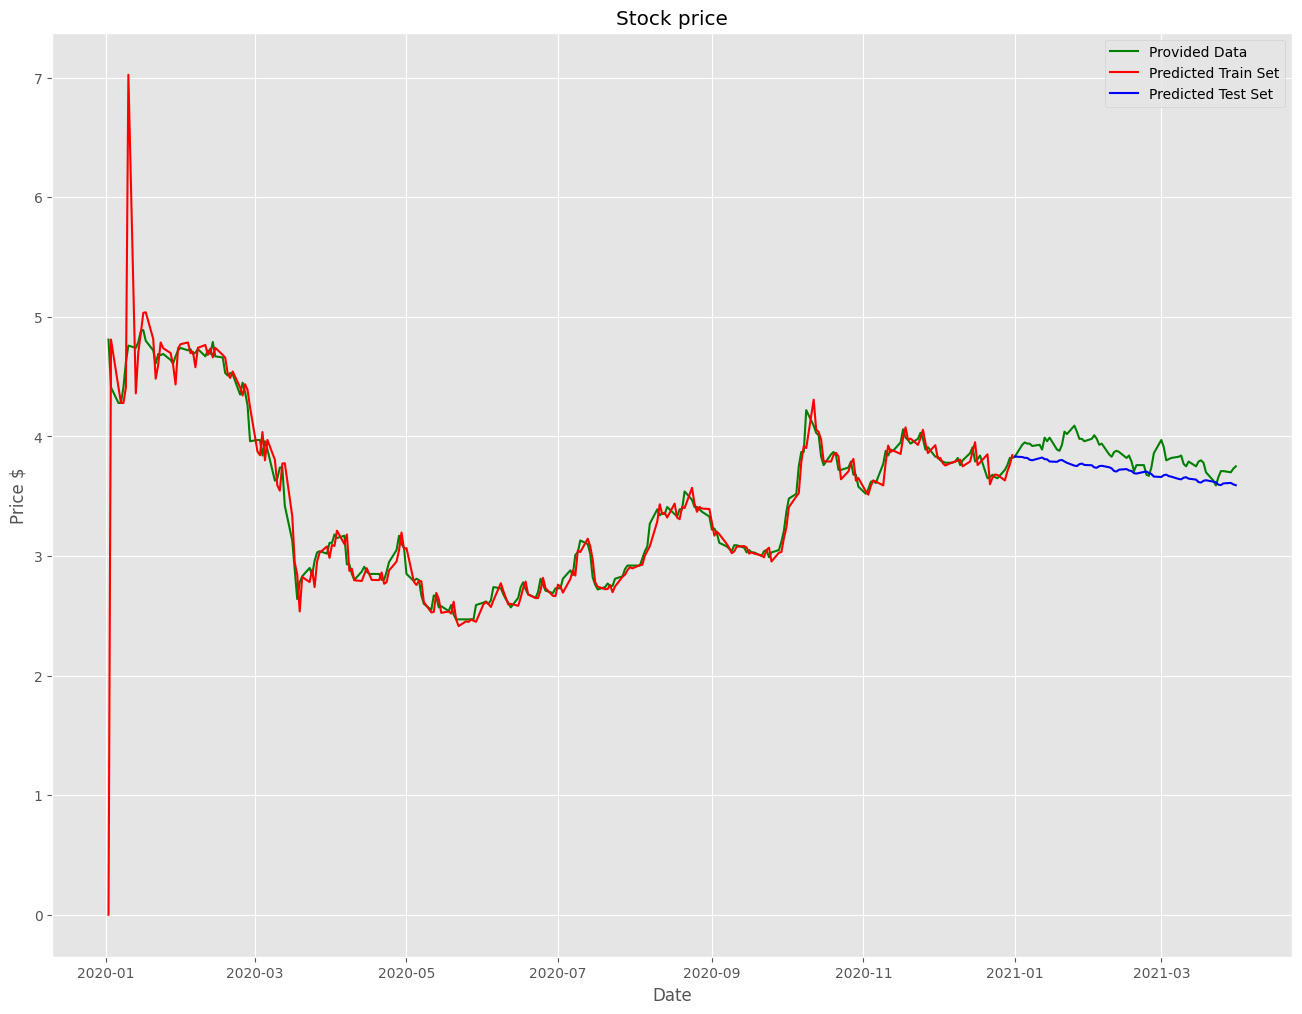

In [40]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C3, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred3.index = C_test3.index
mpl.plot(C_pred3, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

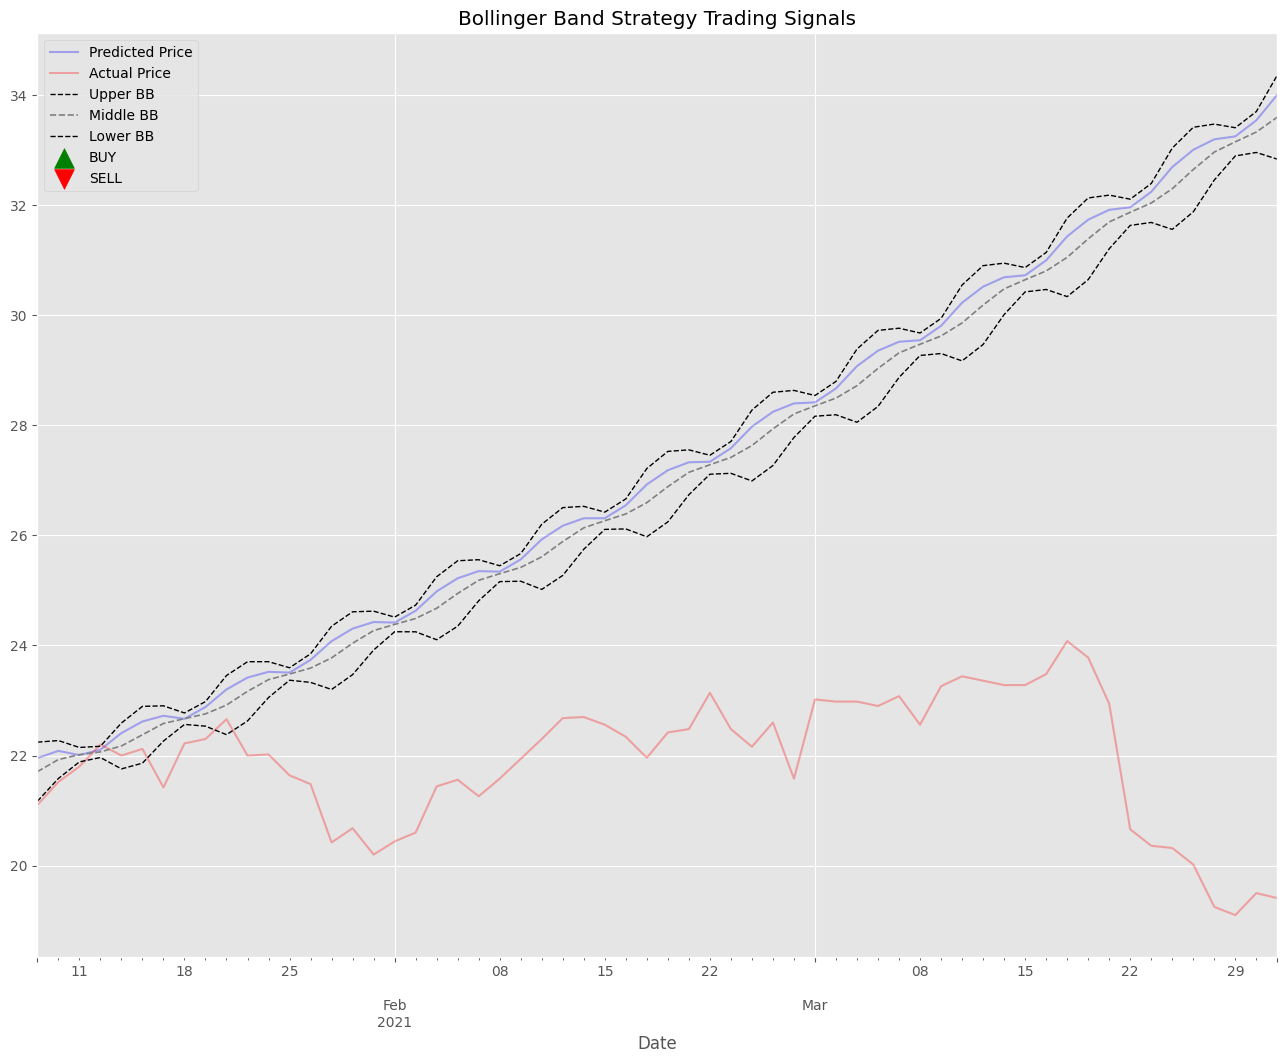

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -2.09%


In [41]:
df_pred3 = pd.DataFrame({'test_set':C_test3, 'predicted':C_pred3})
df_pred3 = bollinger_bands(df_pred2, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred3['predicted'], df_pred3['lower'], df_pred3['upper'])
plot_bollinger(df_pred3, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test3)

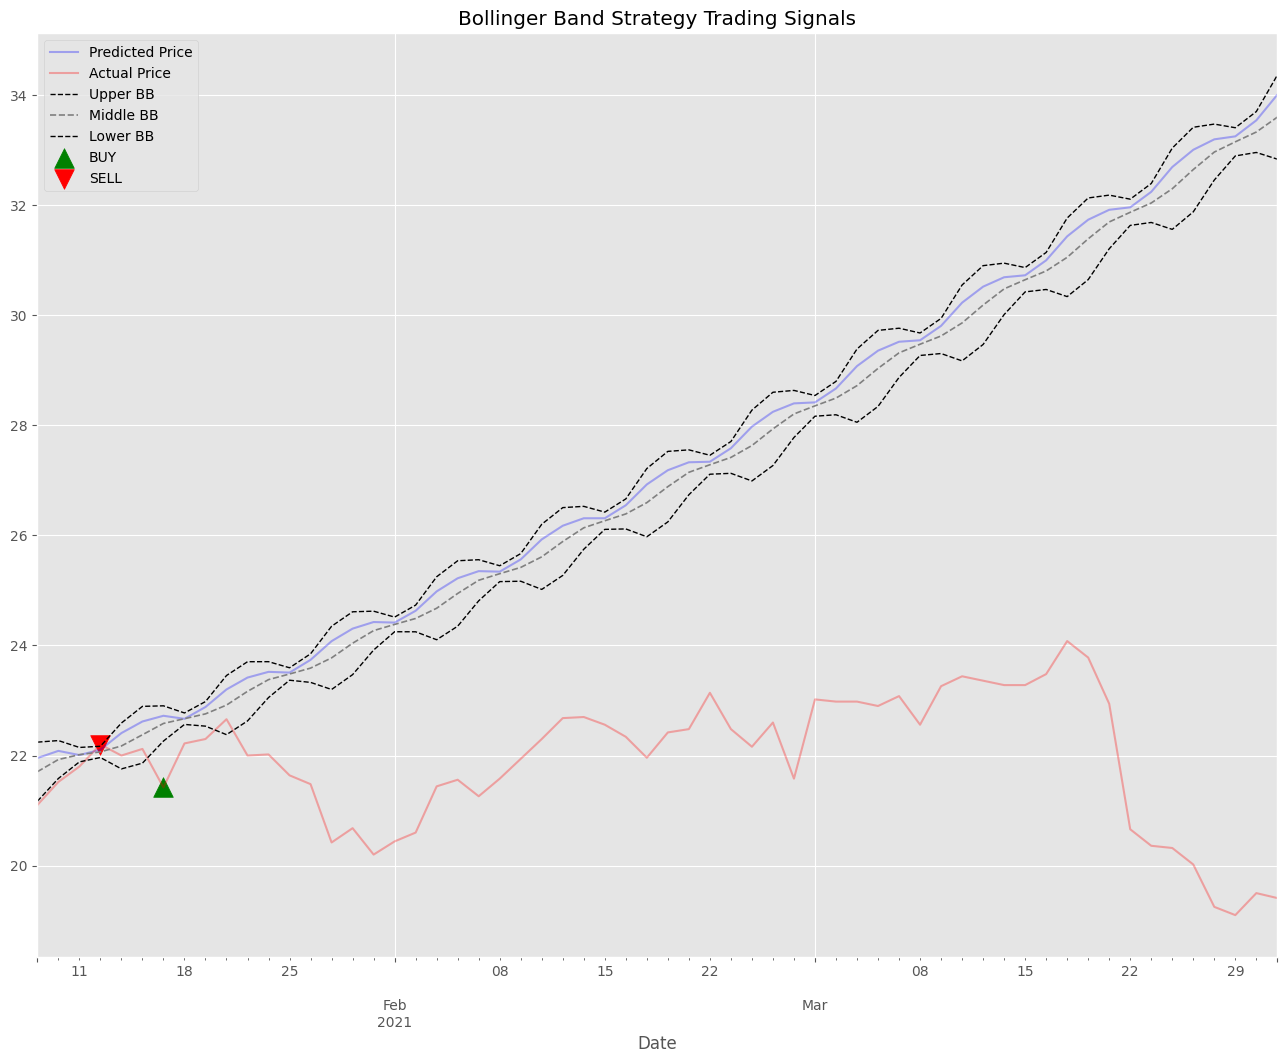

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -2.09%


In [42]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred3['test_set'], df_pred3['lower'], df_pred3['upper'])
plot_bollinger(df_pred3, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test3)

# Minerva SABrazil (BEEF

Brazil - Minerva SABrazil (BEEF


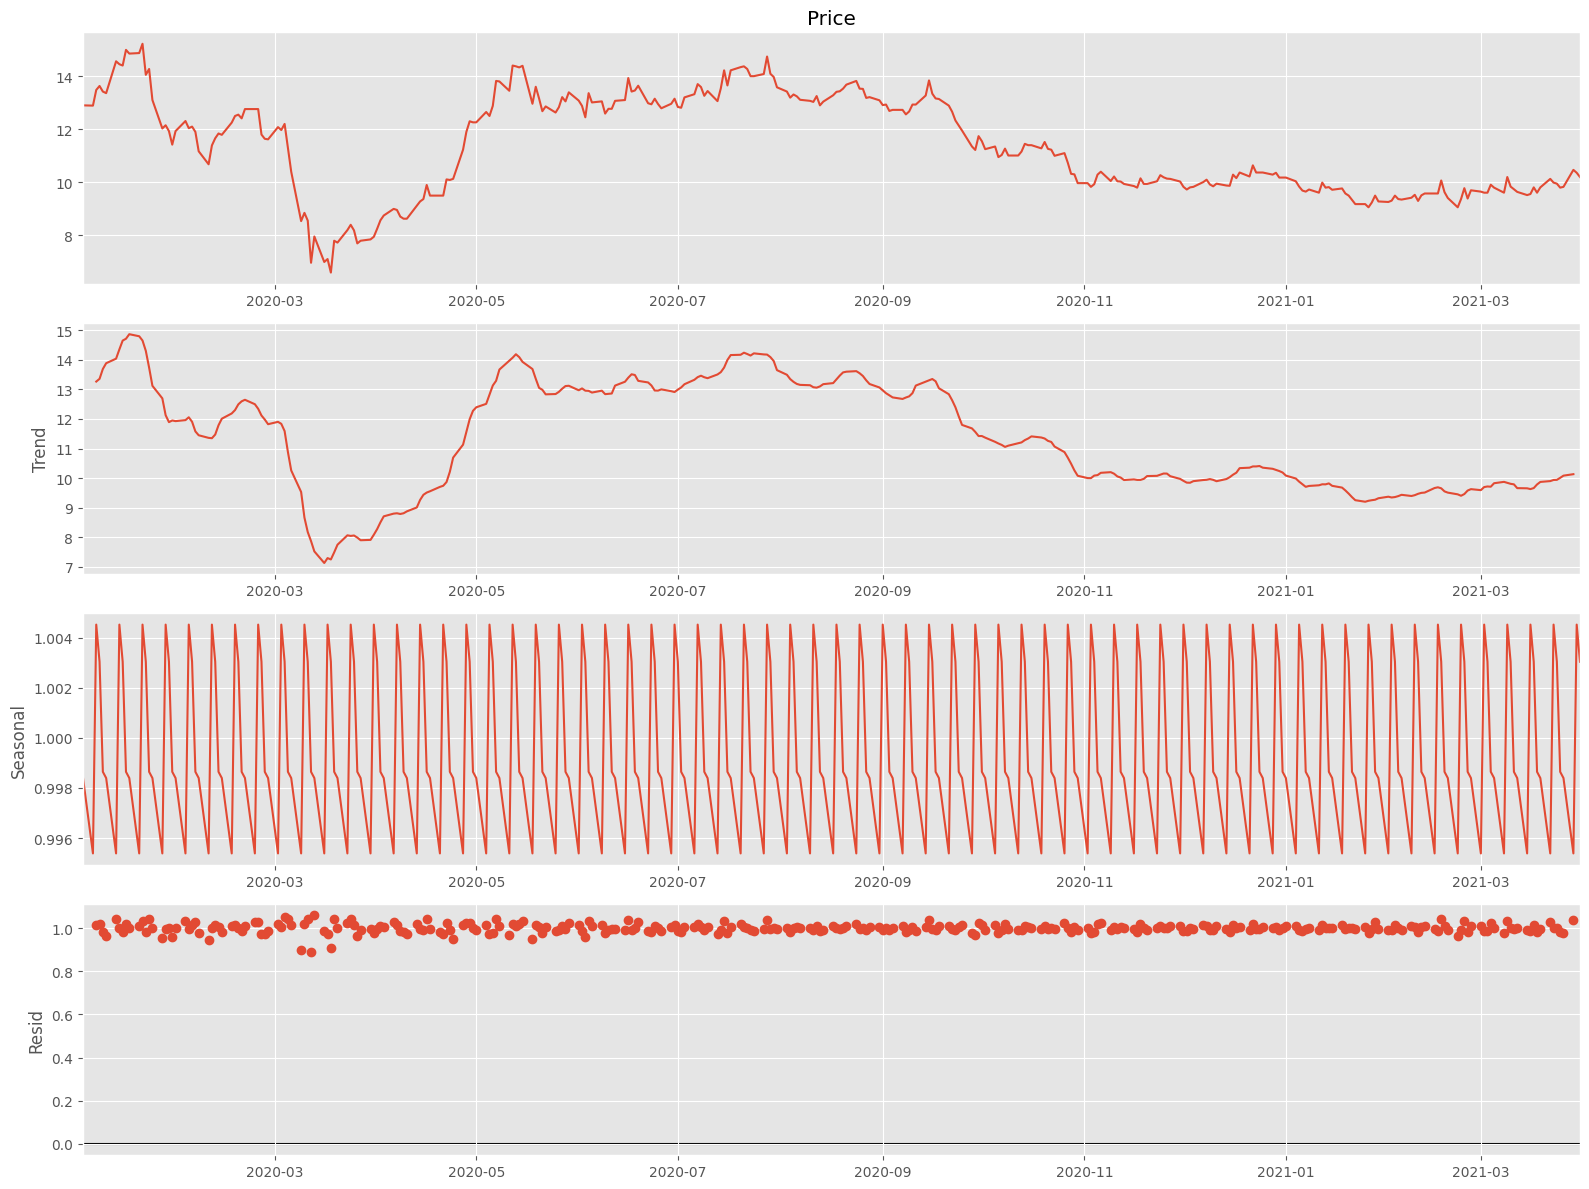

KPSS statistic: 0.695630014493611
p-value: 0.013942725955126276
# lags : 11
KPSS statistic: 0.06640435327873521
p-value: 0.1
# lags : 10


In [43]:
company = list(df_f.keys())[3]
print(company)
df4 = df_f[company]

df4 = df4.resample('B').mean()
df4.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df4['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C4 = df4['Price']
# Check for stationarity
get_kpss_stat(C4)

C_d4 = C4.diff(5).dropna()
get_kpss_stat(C_d4)

In [44]:
train_len4 = (C4.index.year==2020).sum()
C_train4 = C4[:train_len4]
C_test4 = C4[train_len4:]


train_len_d4 = (C_d4.index.year==2020).sum()
C_d_train4 = C_d4[:train_len_d4]
C_d_test4 = C_d4[train_len_d4:]

In [45]:
pdq_ARIMA = auto_arima(C_d_train4, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=706.941, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=435.997, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=560.248, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=705.889, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=437.997, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=437.997, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=435.380, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=431.548, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=435.287, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=428.364, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=428.321, Time=0.18 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=420.134, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=400.129, Time=0.34 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time

In [46]:
total_len4= C4.shape[0]
train_len4 = (C4.index.year==2020).sum()
model = SARIMAX(C_train4, order = (p,d+1,q), seasonal_order= (p,d+1,q,6))
model = model.fit()
C_pred4 = model.predict(start = train_len4, end = total_len4-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 6)   Log Likelihood                -133.211
Date:                           Thu, 30 Mar 2023   AIC                            292.422
Time:                                   00:15:32   BIC                            338.356
Sample:                               01-03-2020   HQIC                           310.903
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1354      2.724     -0.050      0.960      -5.474       5.203
ar.L2          0.1407      0.284      0.495      0.621      -0.417       0.698
ar.L3          0.1857      0.412      0.451      0.652      -0.622       0.993
ar.L4          0.0107      0.515      0.021      0.983      -0.999       1.020
ar.L5         -0.0846      0.059     -1.427      0.153      -0.201       0.032
ma.L1          0.0324      2.715      0.012      0.990      -5.290       5.355
ar.S.L6        0.0150      0.252      0.059      0.953      -0.479       0.509
ar.S.L12      -0.0096      0.075     -0.128      0.898      -0.157       0.138
ar.S.L18      -0.1248      0.076     -1.632      0.103      -0.275       0.025
ar.S.L24       0.0175      0.101      0.173      0.863      -0.181       0.216
ar.S.L30       0.0296      0.076      0.387      0.699      -0.120       0.179
ma.S.L6       -0.9821      0.186     -5.278      0.000      -1.347      -0.617
sigma2         0.1553      0.026      6.005      0.000       0.105       0.206
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                33.49
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

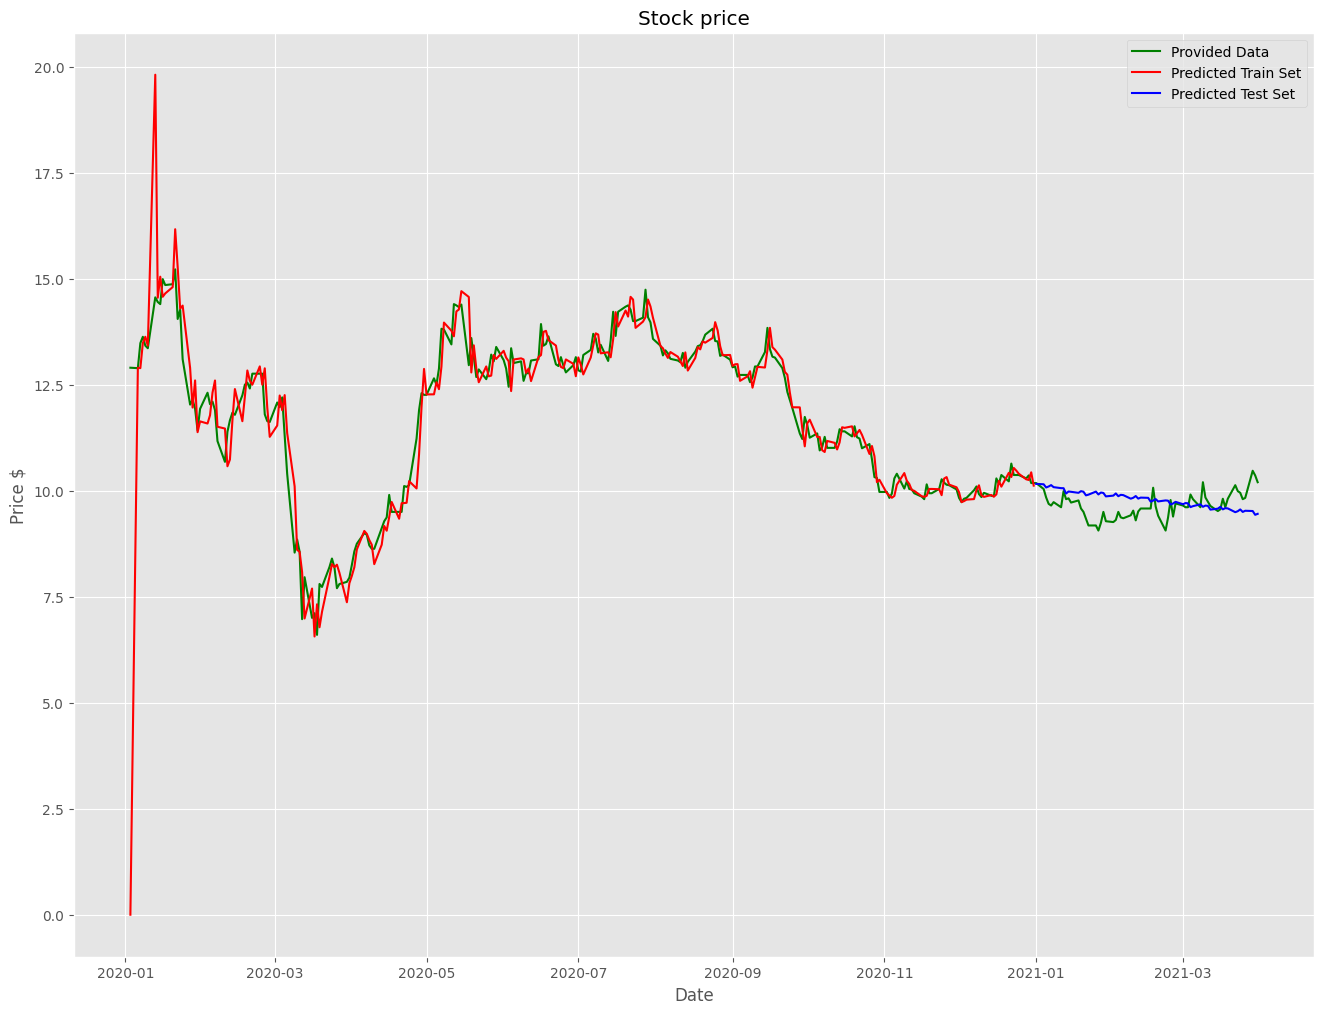

In [47]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C4, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred4.index = C_test4.index
mpl.plot(C_pred4, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

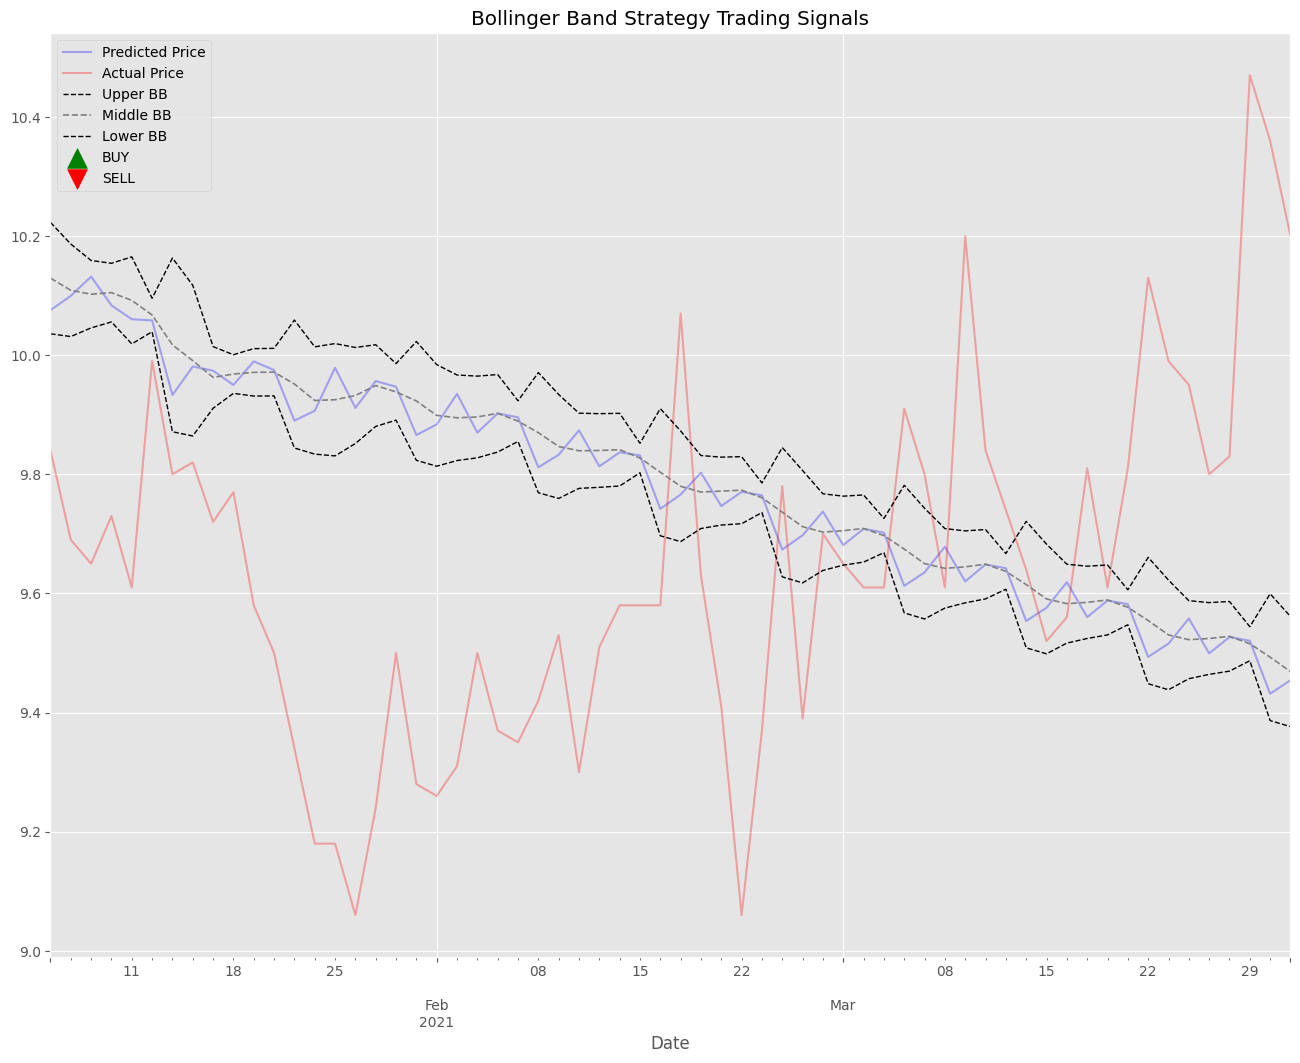

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 0.2%


In [48]:
df_pred4 = pd.DataFrame({'test_set':C_test4, 'predicted':C_pred4})
df_pred4 = bollinger_bands(df_pred4, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred4['predicted'], df_pred4['lower'], df_pred4['upper'])
plot_bollinger(df_pred4, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test4)

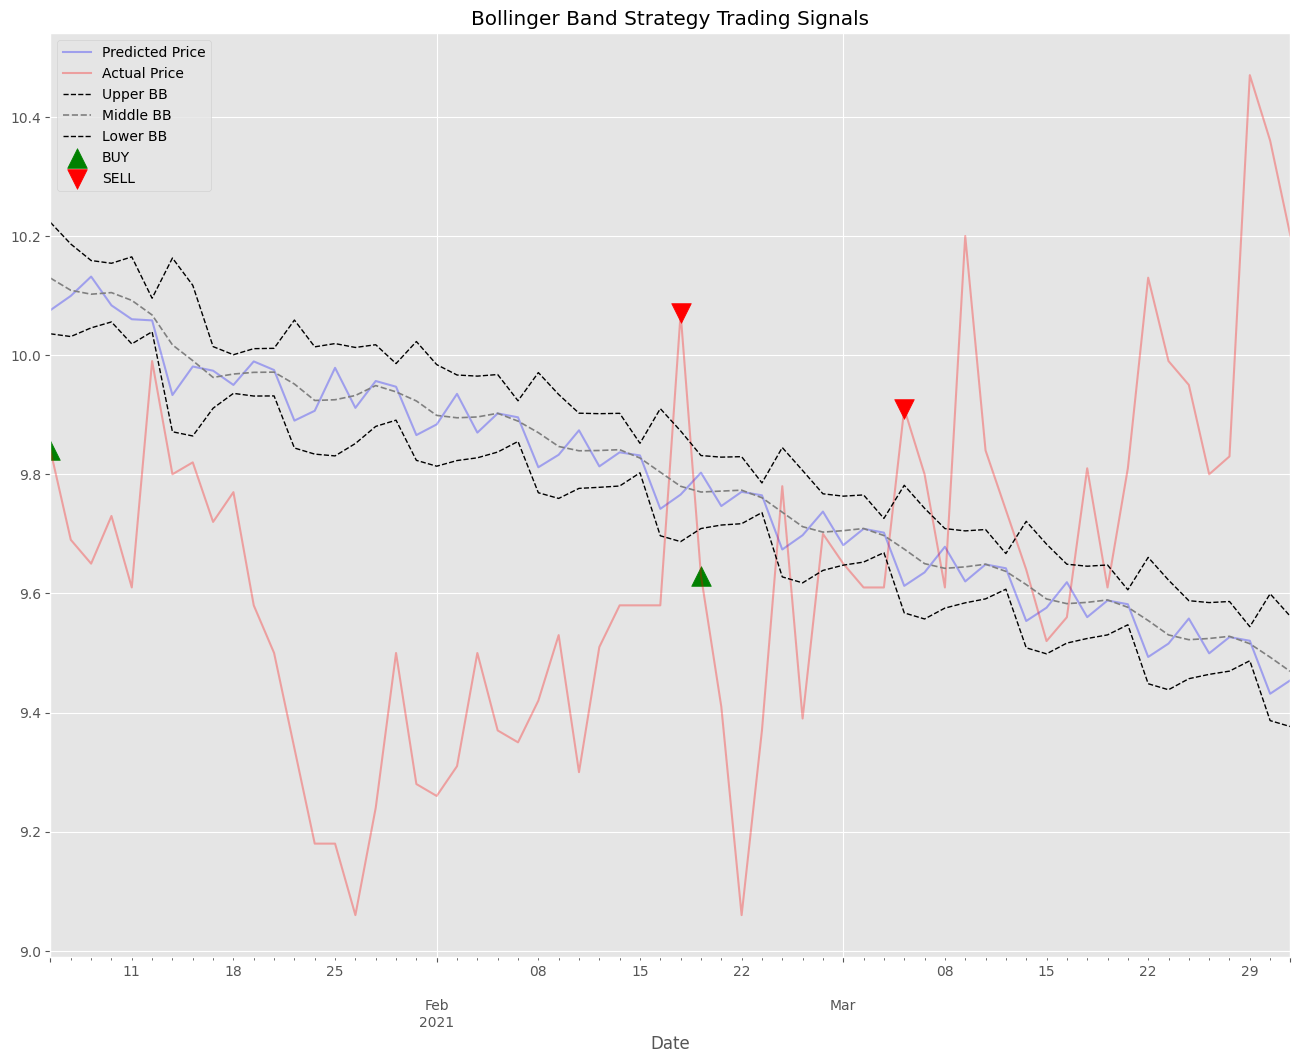

Return using Bollinger Band Strategy is 5.18%.
Return from do nothing strategy is 0.2%


In [49]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred4['test_set'], df_pred4['lower'], df_pred4['upper'])
plot_bollinger(df_pred4, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test4)

#Argentina - Pampa Energia SA (P



Argentina - Pampa Energia SA (P


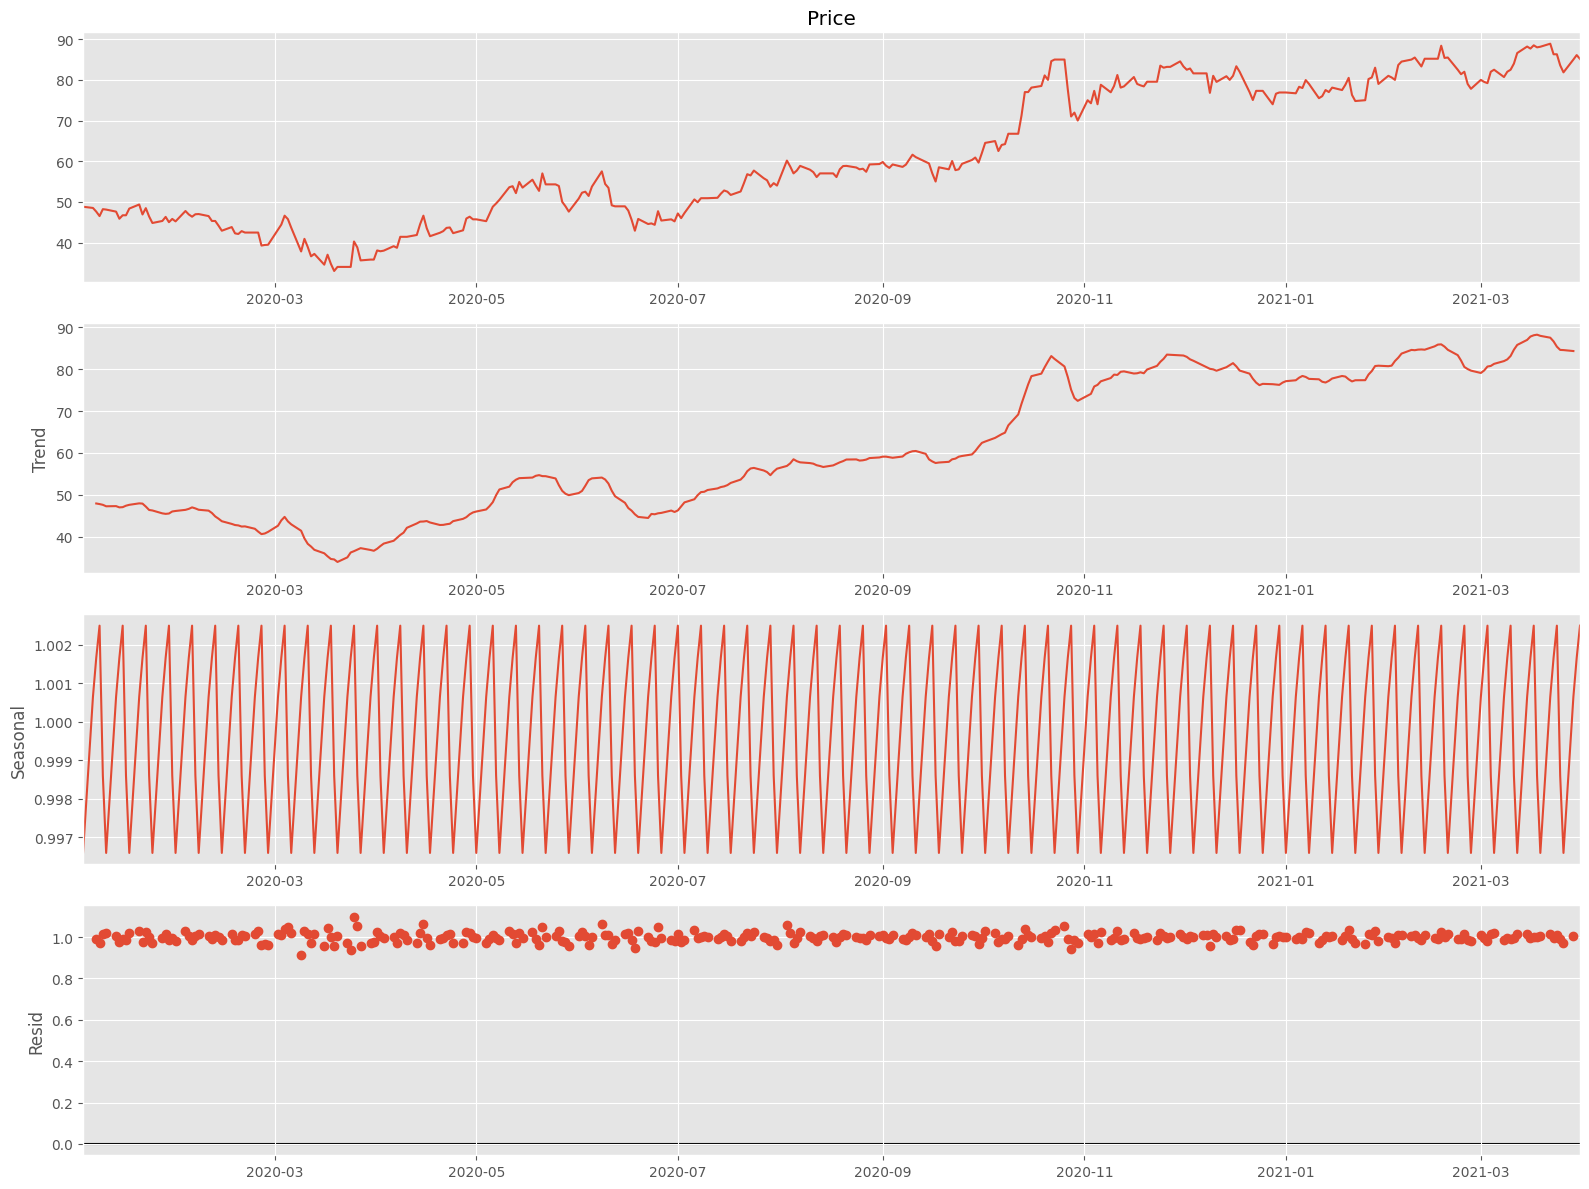

KPSS statistic: 2.5876556405887454
p-value: 0.01
# lags : 11
KPSS statistic: 0.11451637065393794
p-value: 0.1
# lags : 9


In [51]:
company = list(df_f.keys())[4]
print(company)
df5 = df_f[company]

df5 = df5.resample('B').mean()
df5.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df5['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C5 = df5['Price']
# Check for stationarity
get_kpss_stat(C5)

C_d5 = C5.diff(5).dropna()
get_kpss_stat(C_d5)

In [52]:
train_len5 = (C5.index.year==2020).sum()
C_train5 = C5[:train_len5]
C_test5 = C5[train_len5:]


train_len_d5 = (C_d5.index.year==2020).sum()
C_d_train5 = C_d5[:train_len_d5]
C_d_test5 = C_d5[train_len_d5:]

In [53]:
pdq_ARIMA = auto_arima(C_d_train5, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1192.317, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1436.371, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1218.166, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1312.160, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1439.241, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1212.988, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1216.794, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1204.454, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1219.798, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1197.196, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1207.484, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1191.918, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1

In [54]:
total_len5= C5.shape[0]
train_len5 = (C5.index.year==2020).sum()
model = SARIMAX(C_train5, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred5 = model.predict(start = train_len5, end = total_len5-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 5)   Log Likelihood                -542.910
Date:                           Thu, 30 Mar 2023   AIC                           1103.820
Time:                                   00:20:03   BIC                           1135.656
Sample:                               01-03-2020   HQIC                          1116.627
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0539      0.565      0.095      0.924      -1.053       1.161
ar.L2          0.5756      0.339      1.699      0.089      -0.088       1.240
ma.L1         -0.1693      0.580     -0.292      0.770      -1.307       0.968
ma.L2         -0.5486      0.360     -1.523      0.128      -1.255       0.158
ar.S.L5       -0.3970      0.464     -0.855      0.393      -1.307       0.513
ar.S.L10      -0.0645      0.103     -0.624      0.533      -0.267       0.138
ma.S.L5       -0.5111      0.626     -0.816      0.415      -1.739       0.717
ma.S.L10      -0.4850      0.545     -0.891      0.373      -1.552       0.582
sigma2         3.8967      1.758      2.216      0.027       0.450       7.343
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                31.22
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

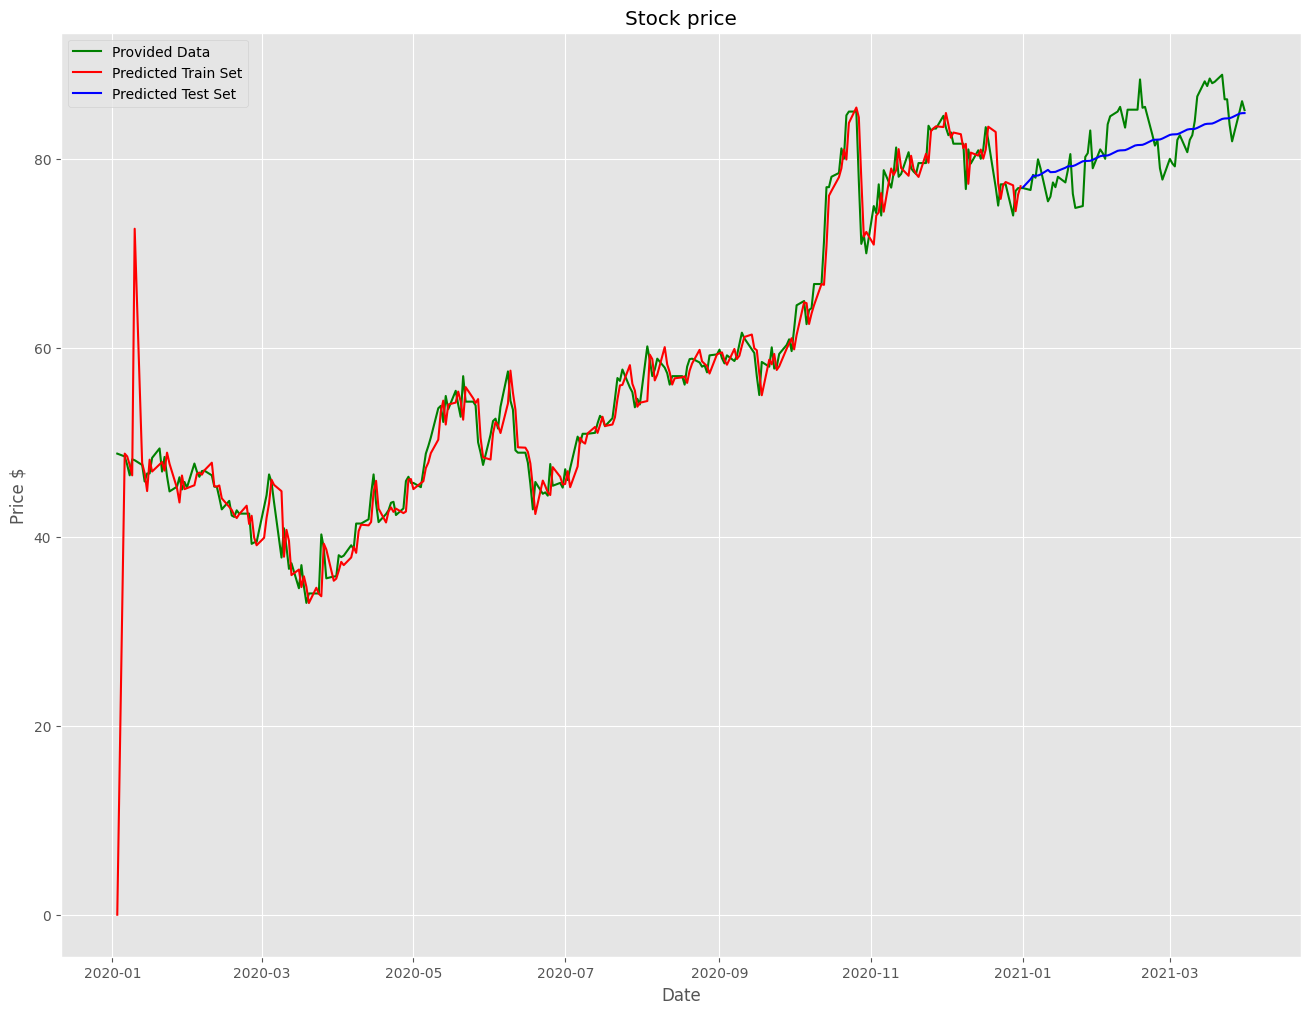

In [55]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C5, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred5.index = C_test5.index
mpl.plot(C_pred5, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

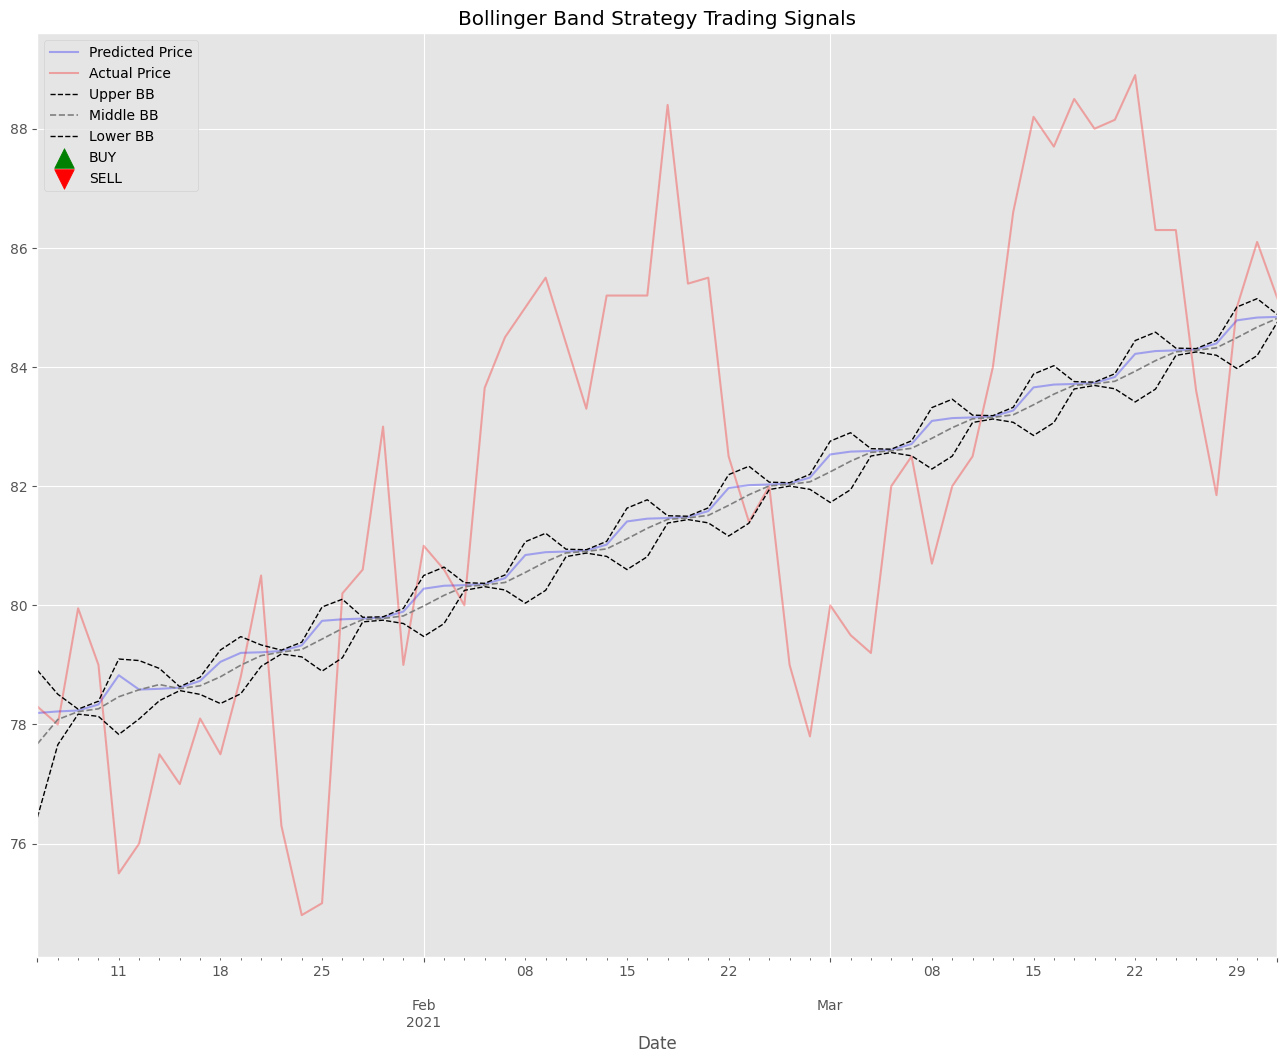

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 10.73%


In [56]:
df_pred5 = pd.DataFrame({'test_set':C_test5, 'predicted':C_pred5})
df_pred5 = bollinger_bands(df_pred5, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred5['predicted'], df_pred5['lower'], df_pred5['upper'])
plot_bollinger(df_pred5, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test5)

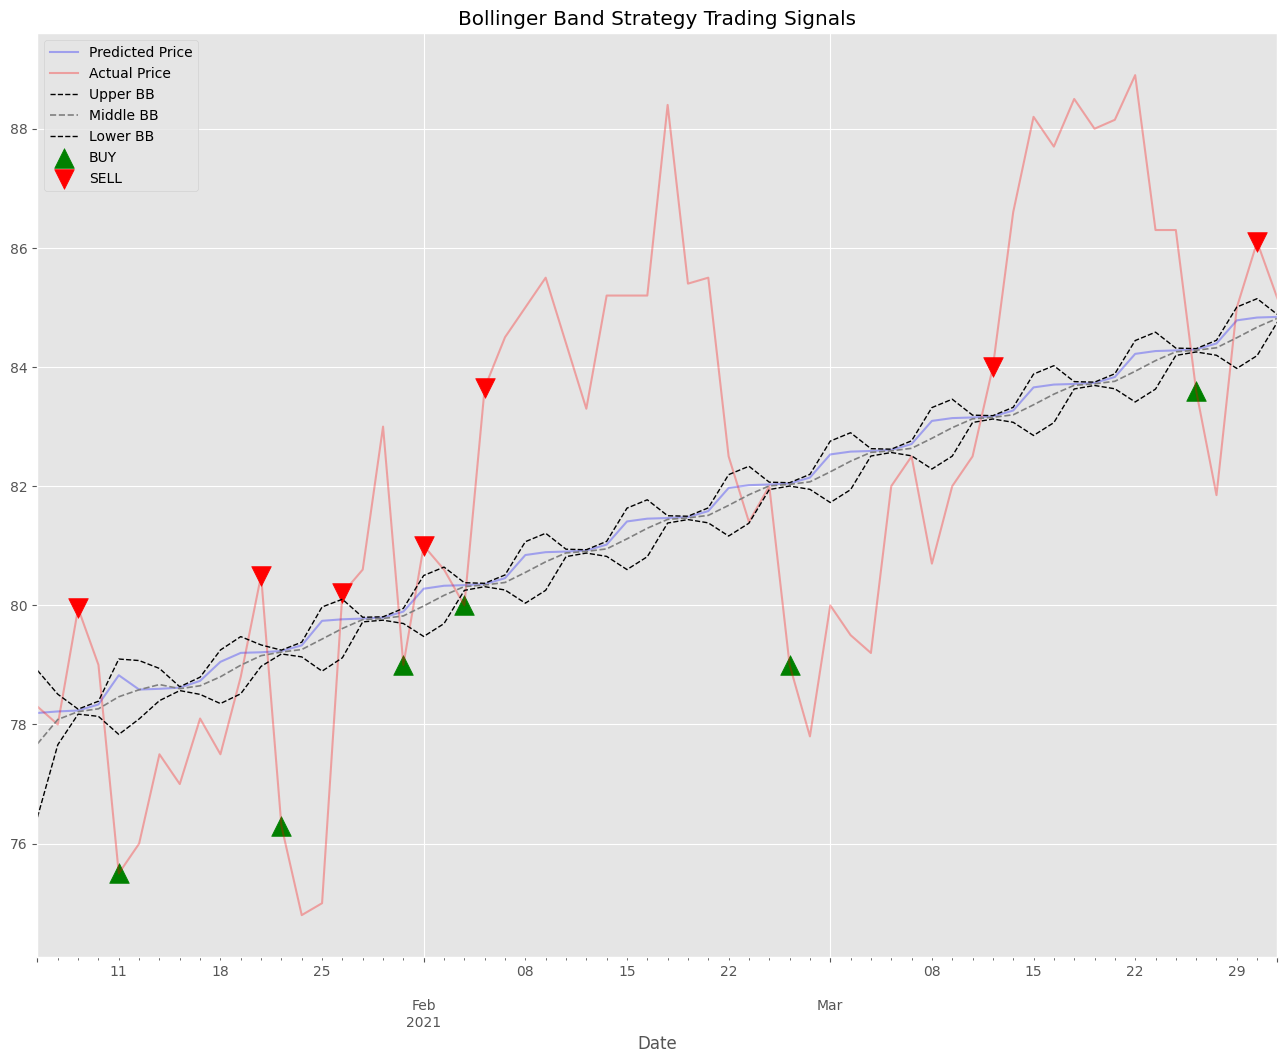

Return using Bollinger Band Strategy is 29.21%.
Return from do nothing strategy is 10.73%


In [72]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred5['test_set'], df_pred5['lower'], df_pred5['upper'])
plot_bollinger(df_pred5, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test5)

#Colombia - Cementos Argos SA (C

Colombia - Cementos Argos SA (C


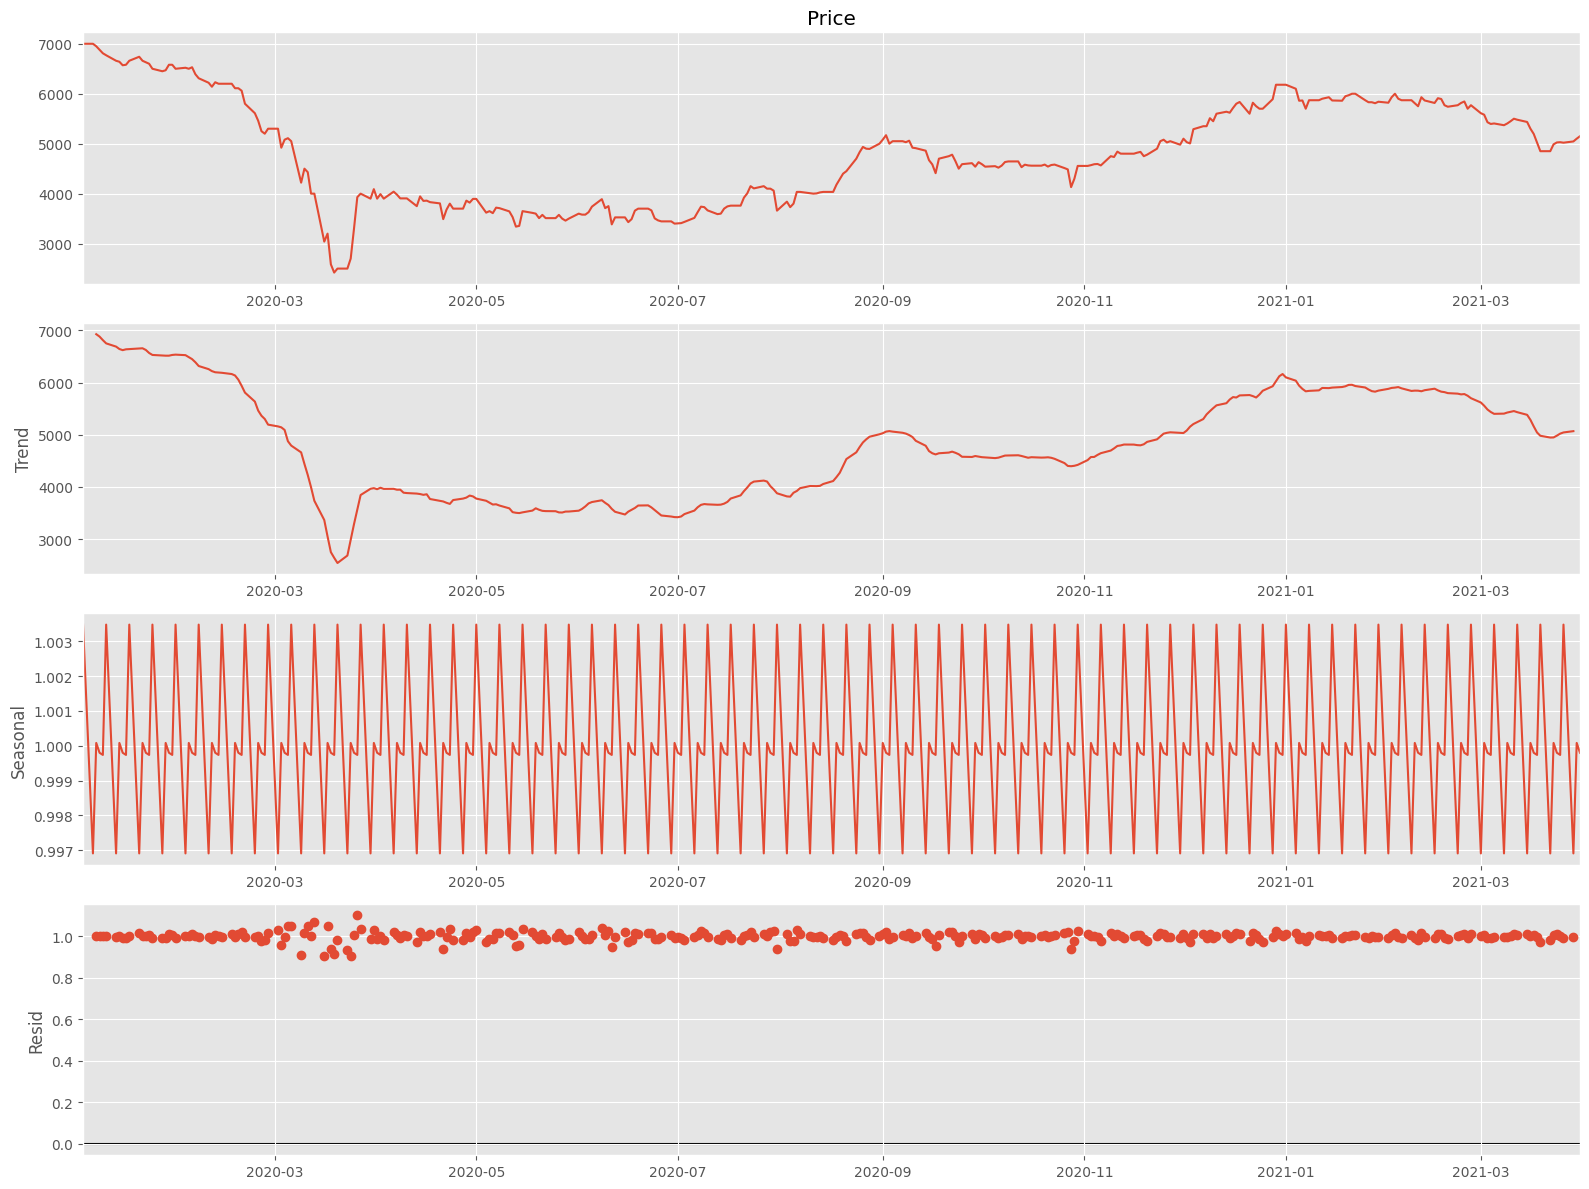

KPSS statistic: 0.6240046283813819
p-value: 0.02045412469260164
# lags : 11
KPSS statistic: 0.3836097496315695
p-value: 0.08421993550363382
# lags : 10


In [75]:
company = list(df_f.keys())[5]
print(company)
df6 = df_f[company]

df6 = df6.resample('B').mean()
df6.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df6['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C6 = df6['Price']
# Check for stationarity
get_kpss_stat(C6)

C_d6 = C6.diff(5).dropna()
get_kpss_stat(C_d6)

In [76]:
train_len6 = (C6.index.year==2020).sum()
C_train6 = C6[:train_len6]
C_test6 = C6[train_len6:]


train_len_d6 = (C_d6.index.year==2020).sum()
C_d_train6 = C_d6[:train_len_d6]
C_d_test6 = C_d6[train_len_d6:]

pdq_ARIMA = auto_arima(C_d_train6, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3441.164, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3441.865, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3442.090, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3439.209, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3442.723, Time=1.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.264 seconds


In [77]:
total_len6= C6.shape[0]
train_len6 = (C6.index.year==2020).sum()
model = SARIMAX(C_train6, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred6 = model.predict(start = train_len6, end = total_len6-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 5)   Log Likelihood               -1887.038
Date:                           Thu, 30 Mar 2023   AIC                           3776.077
Time:                                   00:34:15   BIC                           3779.590
Sample:                               01-03-2020   HQIC                          3777.491
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.377e+05   1.41e+04     16.864      0.000     2.1e+05    2.65e+05
===================================================================================
Ljung-Box (L1) (Q):                  60.67   Jarque-Bera (JB):                68.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

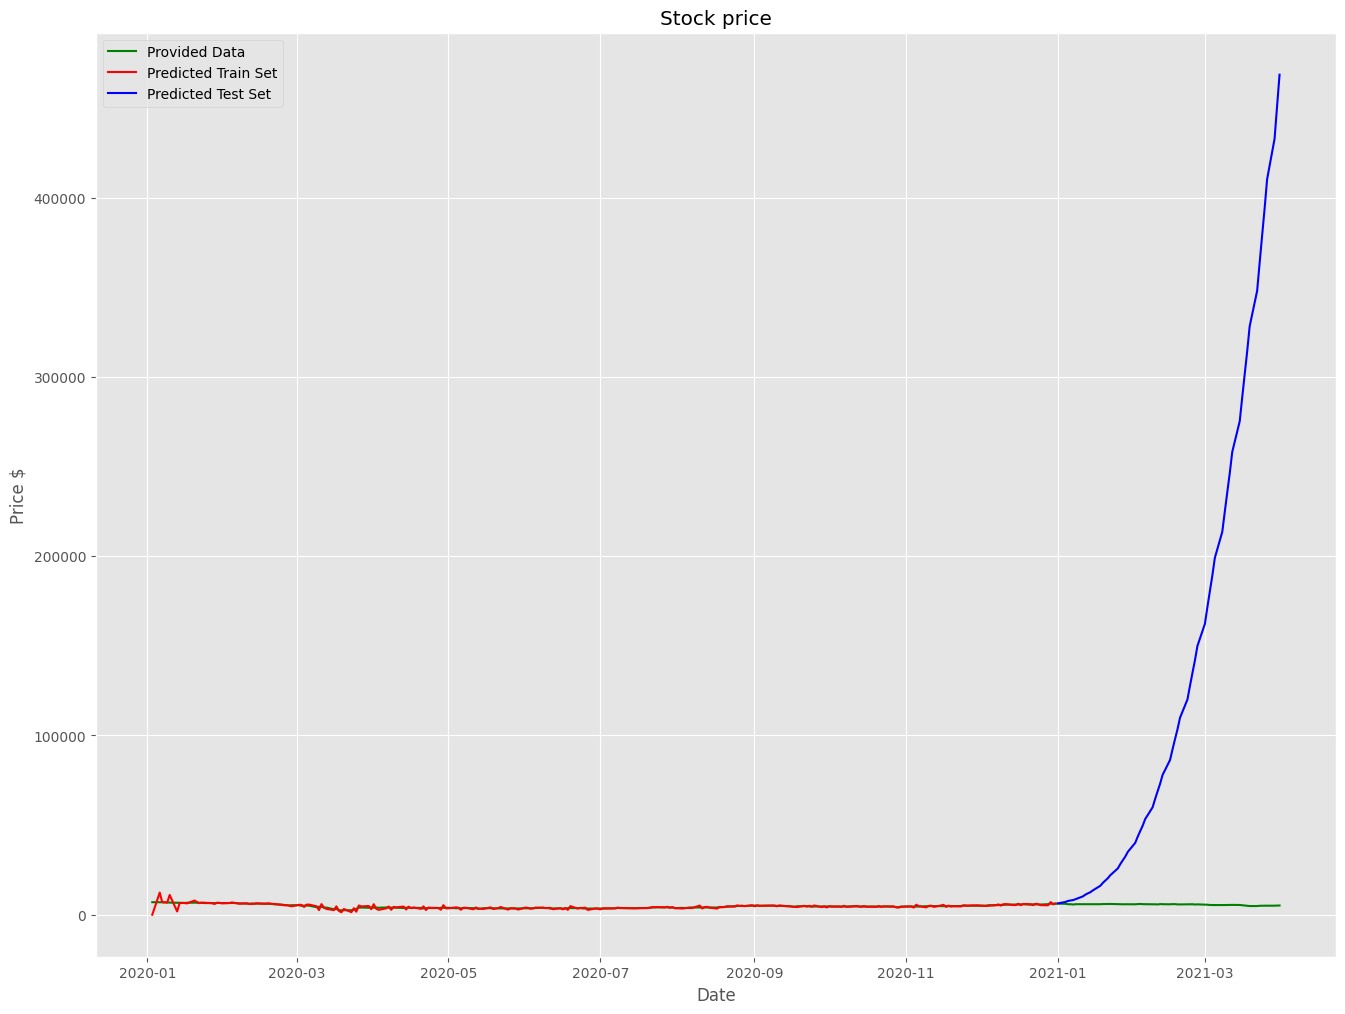

In [78]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C6, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred6.index = C_test6.index
mpl.plot(C_pred6, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

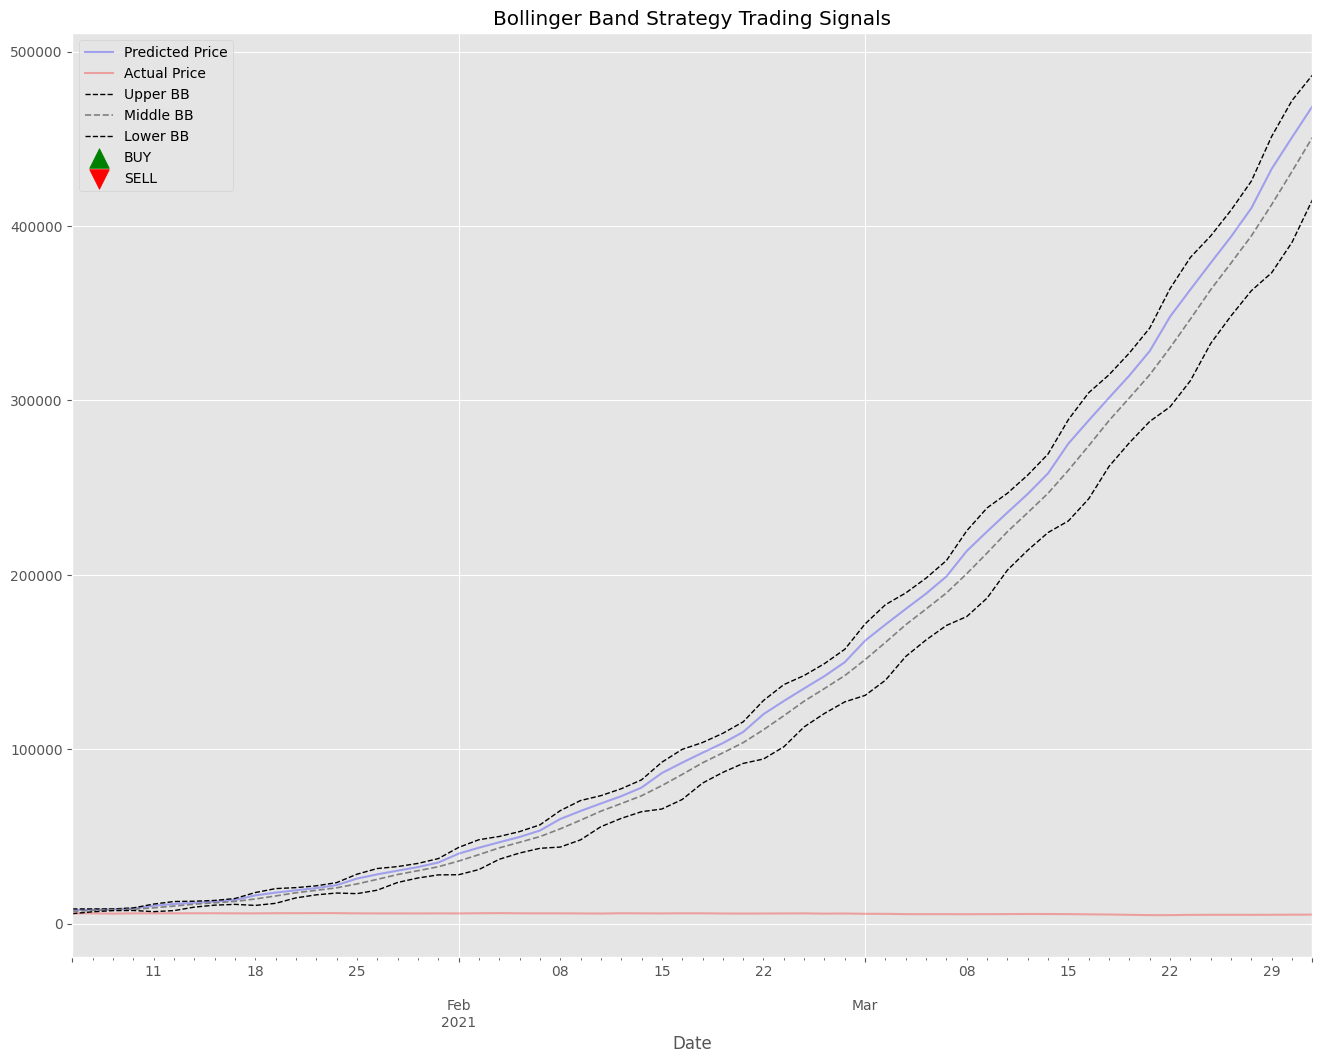

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -16.67%


In [79]:
df_pred6 = pd.DataFrame({'test_set':C_test6, 'predicted':C_pred6})
df_pred6 = bollinger_bands(df_pred6, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred6['predicted'], df_pred6['lower'], df_pred6['upper'])
plot_bollinger(df_pred6, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test6)

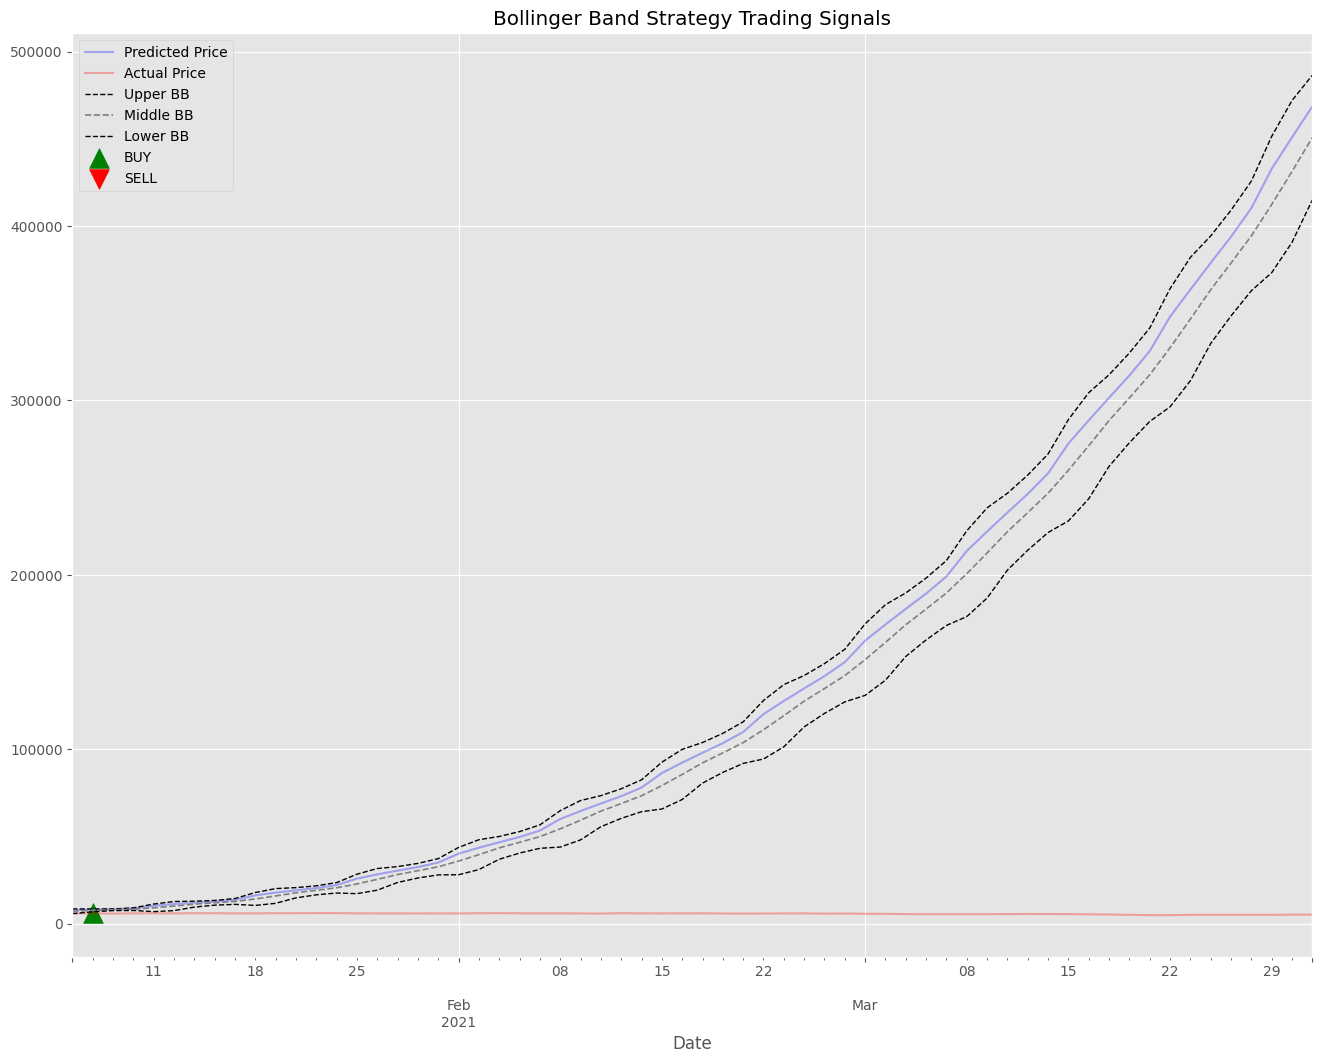

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -16.67%


In [80]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred6['test_set'], df_pred6['lower'], df_pred6['upper'])
plot_bollinger(df_pred6, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test6)

# South Africa - Impala Platinum 

South Africa - Impala Platinum 


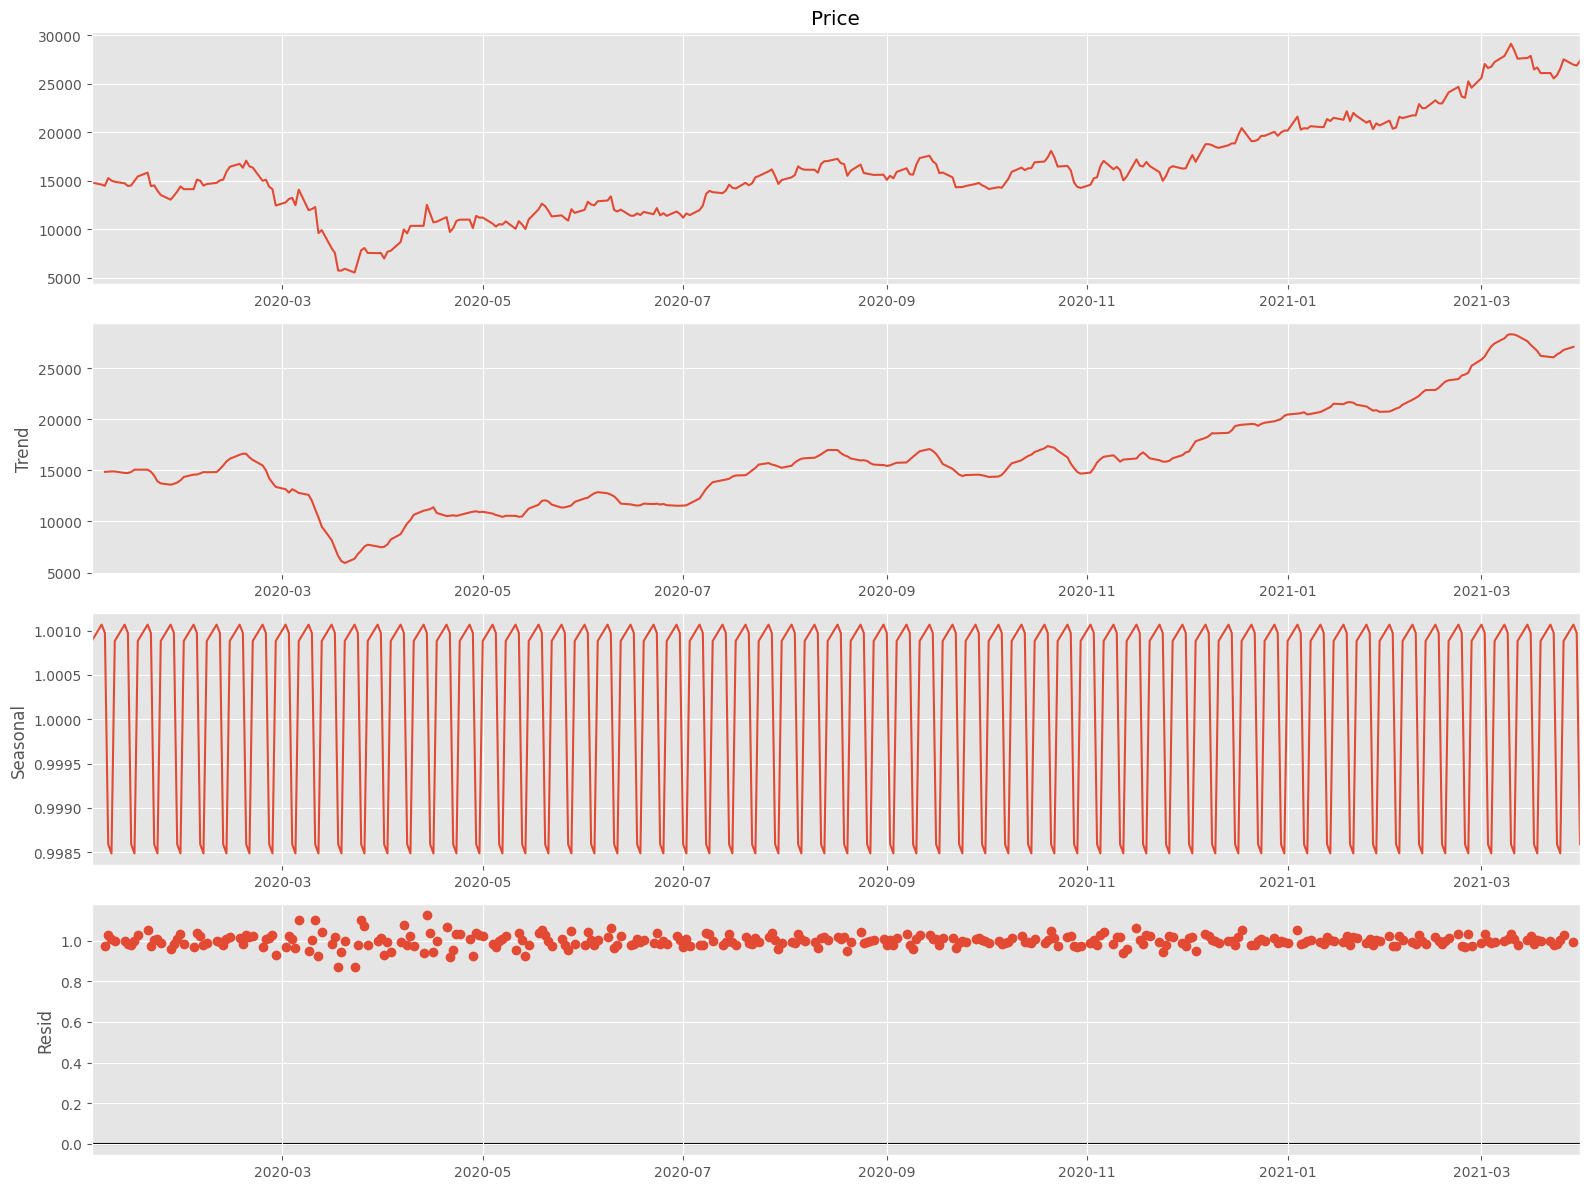

KPSS statistic: 2.0350196603951
p-value: 0.01
# lags : 11
KPSS statistic: 0.31268969188525636
p-value: 0.1
# lags : 9


In [81]:
company = list(df_f.keys())[6]
print(company)
df7 = df_f[company]

df7 = df7.resample('B').mean()
df7.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df7['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C7 = df7['Price']
# Check for stationarity
get_kpss_stat(C7)

C_d7 = C7.diff(5).dropna()
get_kpss_stat(C_d7)

In [74]:
train_len7 = (C7.index.year==2020).sum()
C_train7 = C7[:train_len7]
C_test7 = C7[train_len7:]


train_len_d7 = (C_d7.index.year==2020).sum()
C_d_train7 = C_d7[:train_len_d7]
C_d_test7 = C_d7[train_len_d7:]

pdq_ARIMA = auto_arima(C_d_train7, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4445.756, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4195.975, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4291.952, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4444.917, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4194.397, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4194.421, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4190.075, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4194.956, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4190.595, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4196.611, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4188.456, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4193.138, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4

In [82]:
train_len7 = (C7.index.year==2020).sum()
C_train7 = C7[:train_len7]
C_test7 = C7[train_len7:]


train_len_d7 = (C_d7.index.year==2020).sum()
C_d_train7 = C_d7[:train_len_d7]
C_d_test7 = C_d7[train_len_d7:]

pdq_ARIMA = auto_arima(C_d_train7, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4445.756, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4195.975, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4291.952, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4444.917, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4194.397, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4194.421, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4190.075, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4194.956, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4190.595, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4196.611, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4188.456, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4193.138, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4

In [92]:
total_len7= C7.shape[0]
train_len7 = (C7.index.year==2020).sum()
model = SARIMAX(C_train7, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred7 = model.predict(start = train_len7, end = total_len7-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 5)   Log Likelihood               -2024.958
Date:                           Thu, 30 Mar 2023   AIC                           4071.916
Time:                                   00:49:18   BIC                           4110.827
Sample:                               01-03-2020   HQIC                          4087.570
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      1.161      0.862      0.389      -1.275       3.275
ma.L1         -1.0490      1.688     -0.621      0.534      -4.358       2.260
ma.L2          0.1749      0.127      1.373      0.170      -0.075       0.425
ma.L3          0.1143      0.210      0.543      0.587      -0.298       0.527
ma.L4         -0.2403      0.412     -0.584      0.559      -1.047       0.567
ar.S.L5       -1.0000      0.115     -8.679      0.000      -1.226      -0.774
ma.S.L5        0.1343      0.759      0.177      0.860      -1.353       1.621
ma.S.L10      -1.0497      0.676     -1.553      0.120      -2.374       0.275
ma.S.L15      -0.1142      0.154     -0.742      0.458      -0.416       0.188
ma.S.L20       0.0697      0.080      0.869      0.385      -0.088       0.227
sigma2      4.357e+05   6.88e-06   6.34e+10      0.000    4.36e+05    4.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.96   Prob(JB):                         0.11
Heteroskedasticity (H):               0.55   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+27. Standard errors may be unstable.
"""

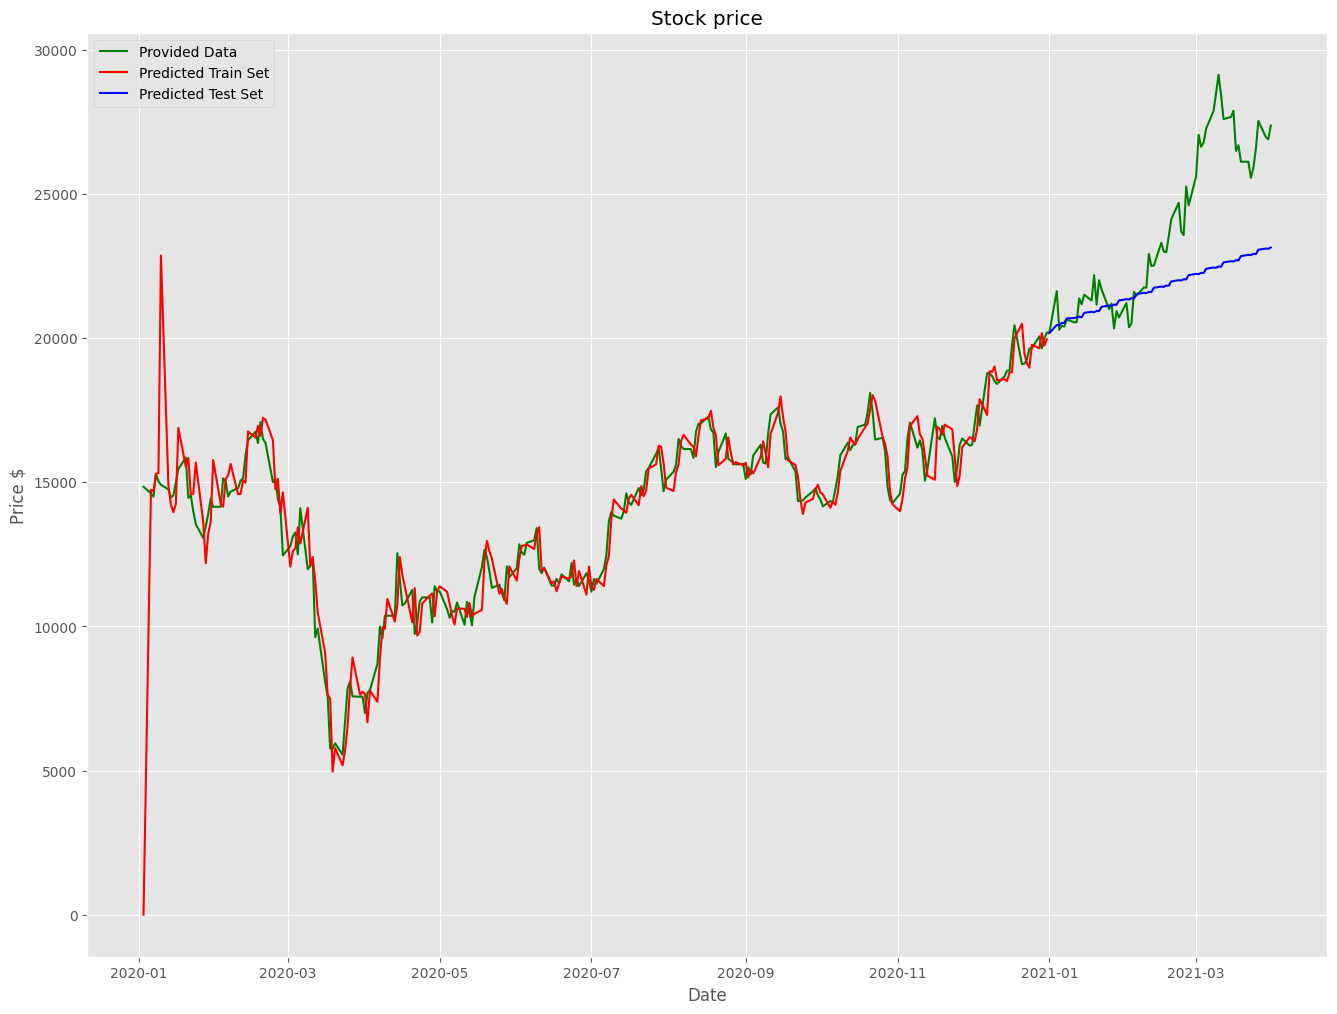

In [93]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C7, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred7.index = C_test7.index
mpl.plot(C_pred7, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

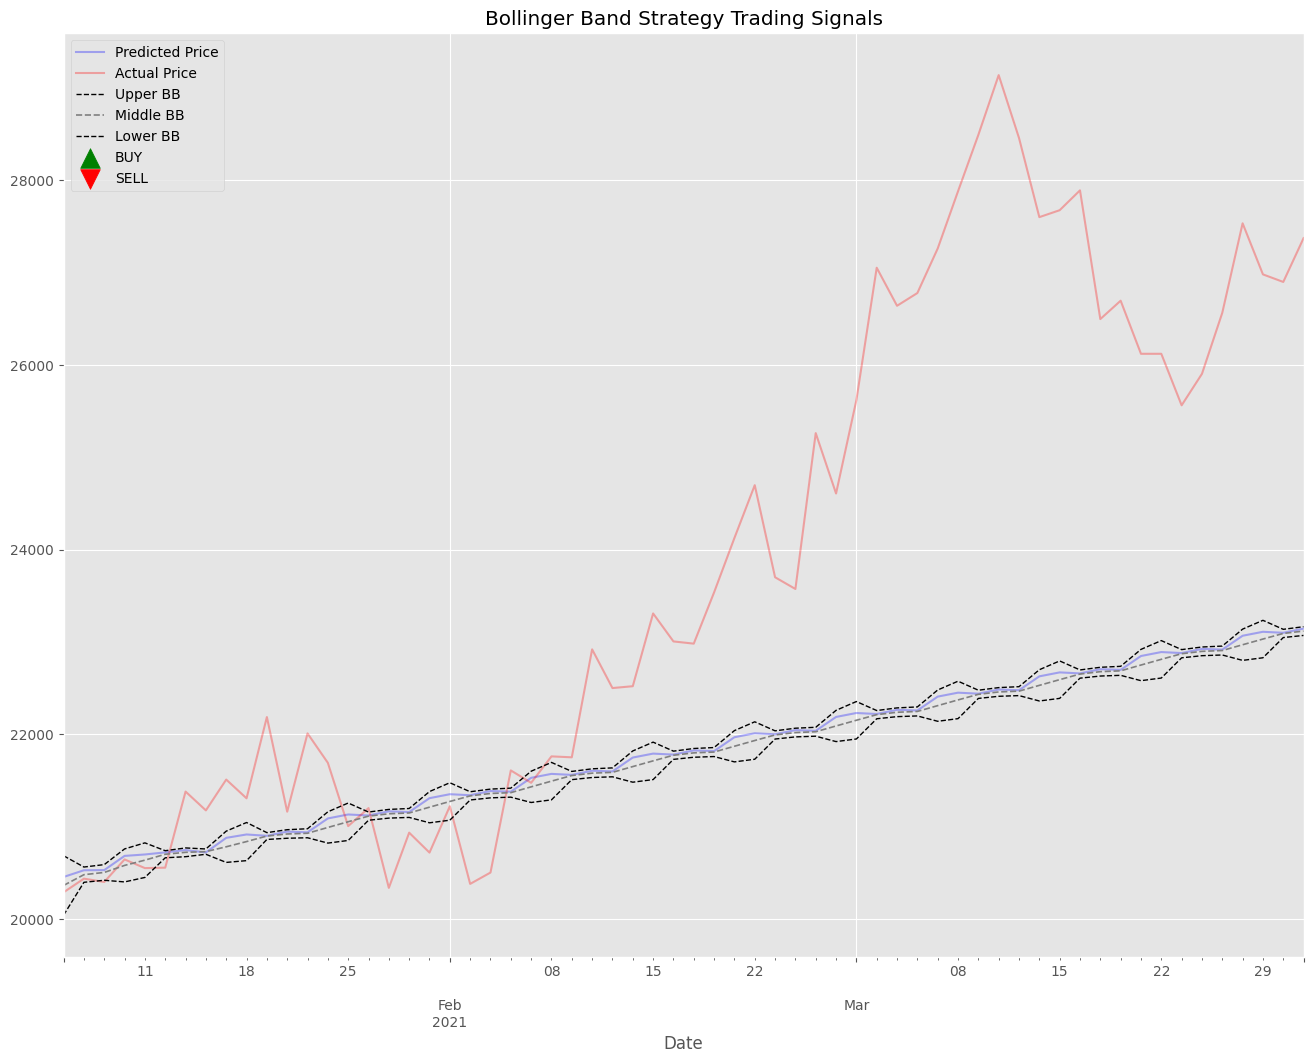

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 35.58%


In [94]:
df_pred7 = pd.DataFrame({'test_set':C_test7, 'predicted':C_pred7})
df_pred7 = bollinger_bands(df_pred7, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred7['predicted'], df_pred7['lower'], df_pred7['upper'])
plot_bollinger(df_pred7, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test7)

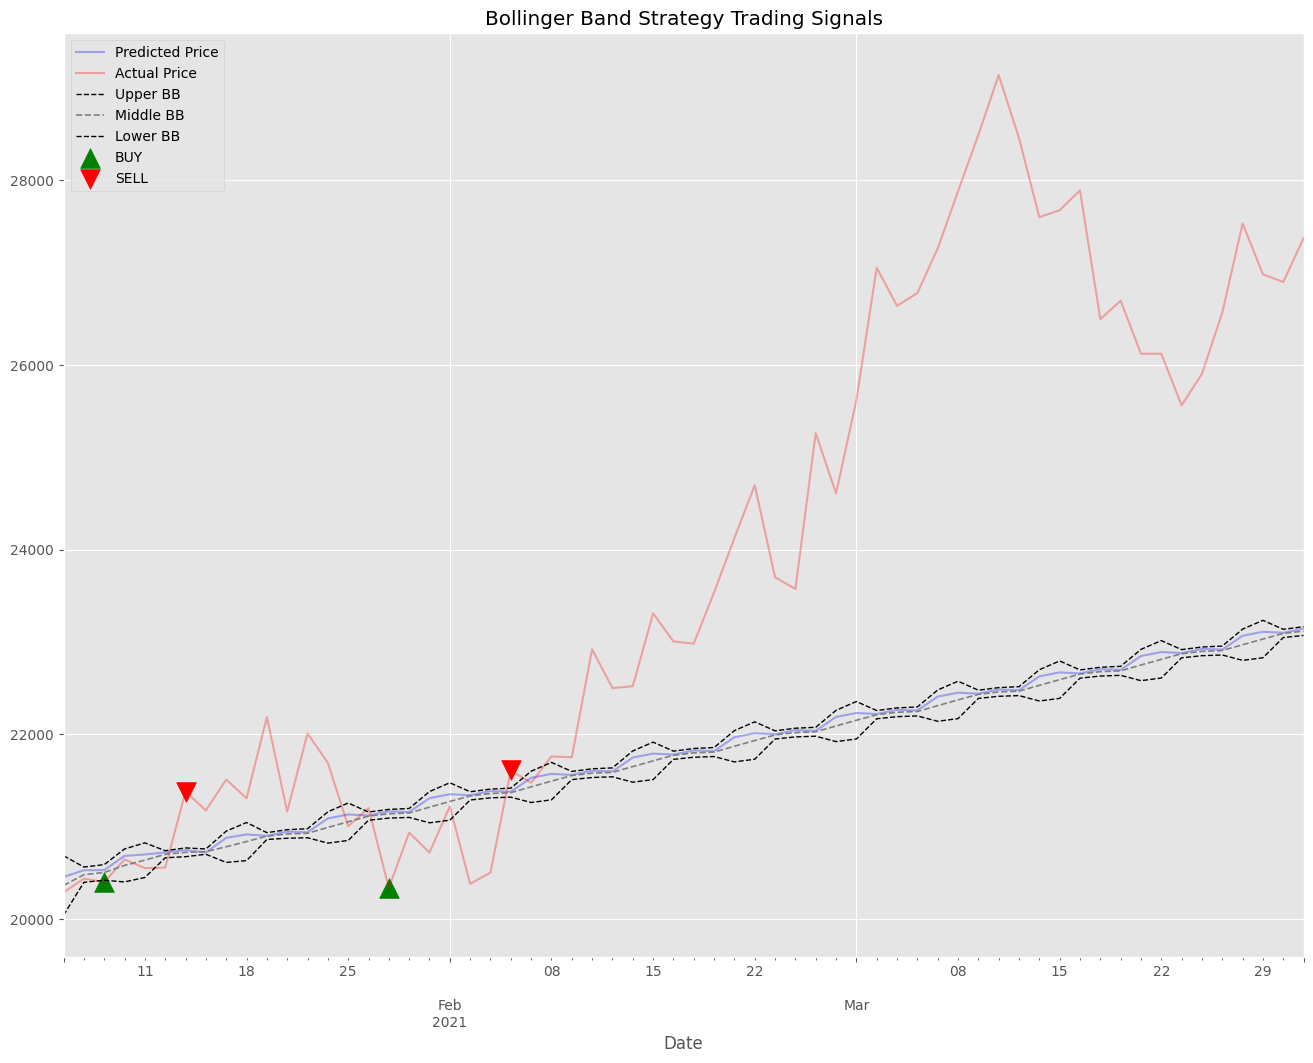

Return using Bollinger Band Strategy is 11.03%.
Return from do nothing strategy is 35.58%


In [95]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred7['test_set'], df_pred7['lower'], df_pred7['upper'])
plot_bollinger(df_pred7, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test7)

# South Korea - Dongkuk Steel Mil

South Korea - Dongkuk Steel Mil


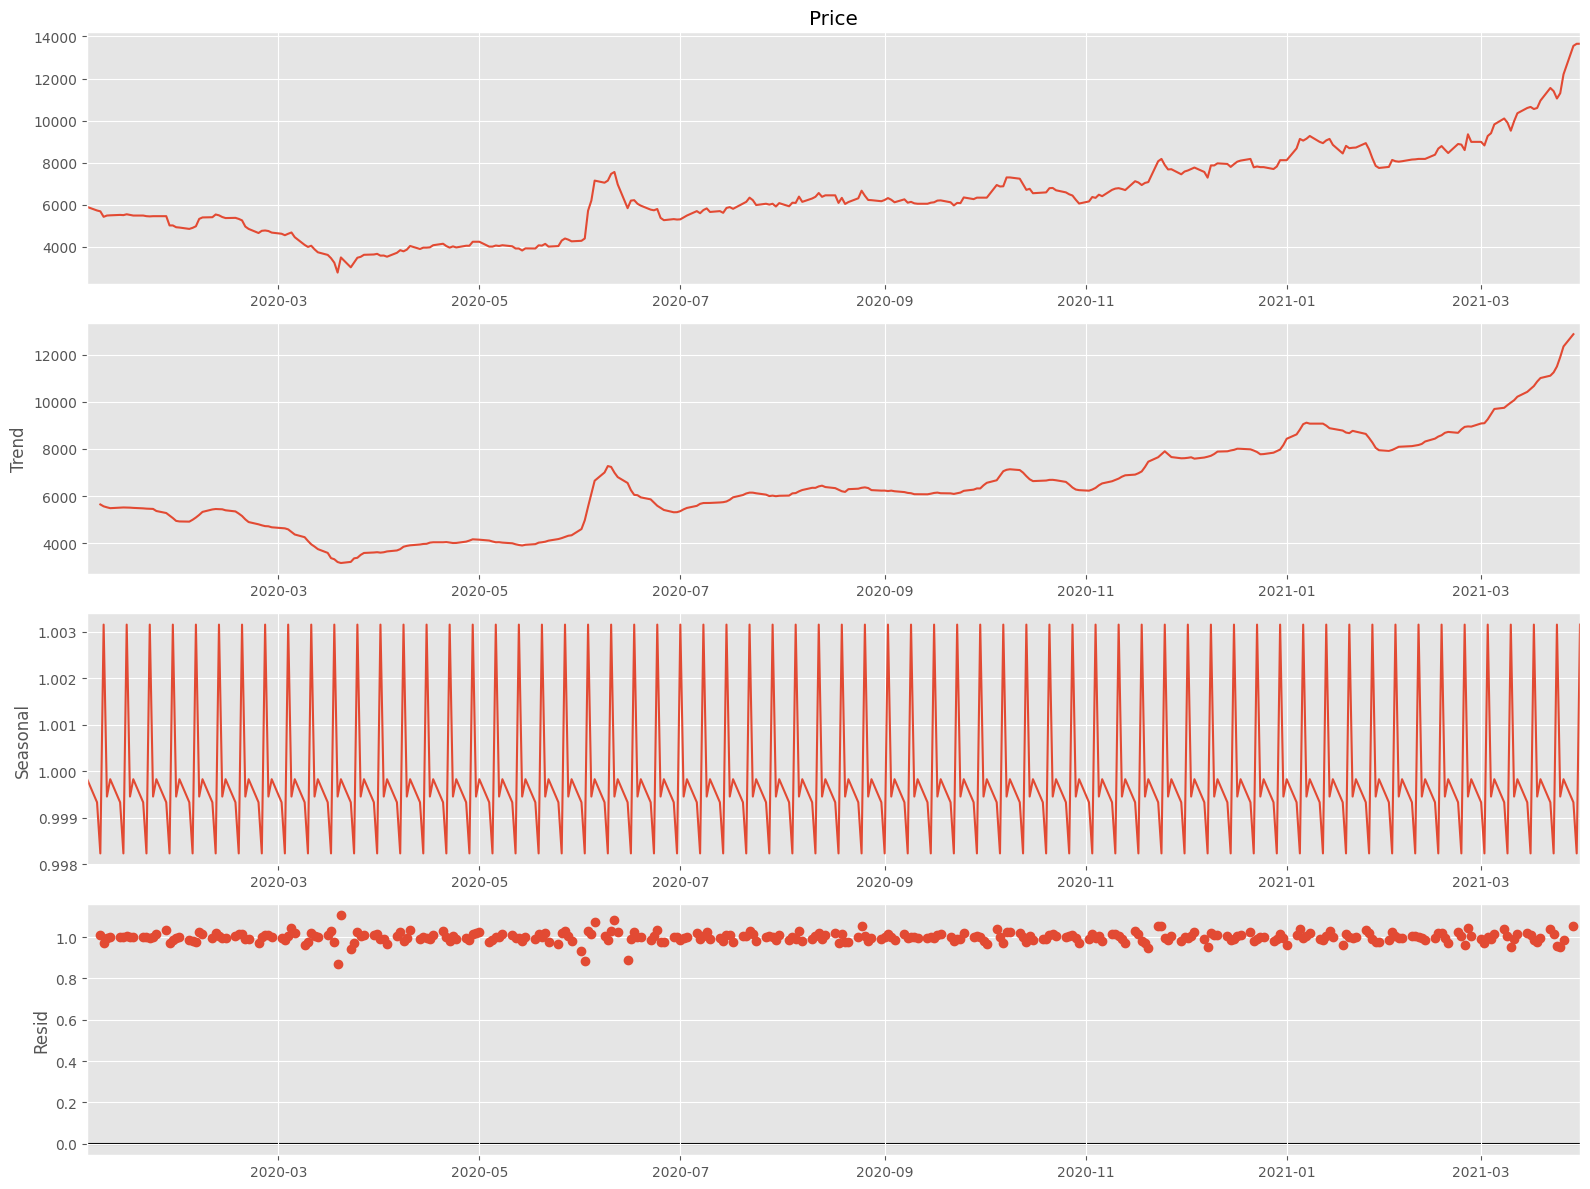

KPSS statistic: 2.3215467388249236
p-value: 0.01
# lags : 11
KPSS statistic: 0.46119217246424643
p-value: 0.050779236006790344
# lags : 10


In [90]:
company = list(df_f.keys())[7]
print(company)
df8 = df_f[company]

df8 = df8.resample('B').mean()
df8.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df8['Price'], model='multiplicative')
decomposition.plot()
mpl.show()
# Set y value
C8 = df8['Price']
# Check for stationarity
get_kpss_stat(C8)

C_d8 = C8.diff(6).dropna()
get_kpss_stat(C_d8)

In [91]:
train_len8 = (C8.index.year==2020).sum()
C_train8 = C8[:train_len8]
C_test8 = C8[train_len8:]


train_len_d8 = (C_d8.index.year==2020).sum()
C_d_train8 = C_d8[:train_len_d8]
C_d_test8 = C_d8[train_len_d8:]

pdq_ARIMA = auto_arima(C_d_train8, trace = True)
p,d,q = pdq_ARIMA.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3623.486, Time=1.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3966.769, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3640.306, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3771.816, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3966.846, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3630.370, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3616.247, Time=0.65 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3617.047, Time=0.43 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3614.487, Time=0.48 s

In [100]:
total_len8= C8.shape[0]
train_len8 = (C8.index.year==2020).sum()
model = SARIMAX(C_train8, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model = model.fit()
C_pred8 = model.predict(start = train_len8, end = total_len8-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  260
Model:             SARIMAX(1, 1, 4)x(1, 1, 4, 5)   Log Likelihood               -1734.150
Date:                           Thu, 30 Mar 2023   AIC                           3490.300
Time:                                   00:51:15   BIC                           3529.210
Sample:                               01-03-2020   HQIC                          3505.953
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9707      0.042    -22.866      0.000      -1.054      -0.888
ma.L1          1.0465      0.115      9.090      0.000       0.821       1.272
ma.L2          0.1514      0.053      2.870      0.004       0.048       0.255
ma.L3          0.0385      0.084      0.458      0.647      -0.126       0.203
ma.L4         -0.0650      0.077     -0.846      0.397      -0.215       0.085
ar.S.L5       -0.9987      0.105     -9.524      0.000      -1.204      -0.793
ma.S.L5        0.0789      0.257      0.307      0.759      -0.425       0.583
ma.S.L10      -1.0144      0.266     -3.810      0.000      -1.536      -0.493
ma.S.L15      -0.0544      0.073     -0.744      0.457      -0.198       0.089
ma.S.L20       0.0497      0.106      0.468      0.640      -0.159       0.258
sigma2      4.676e+04   6121.033      7.639      0.000    3.48e+04    5.88e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               552.02
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.85
Prob(H) (two-sided):                  0.03   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

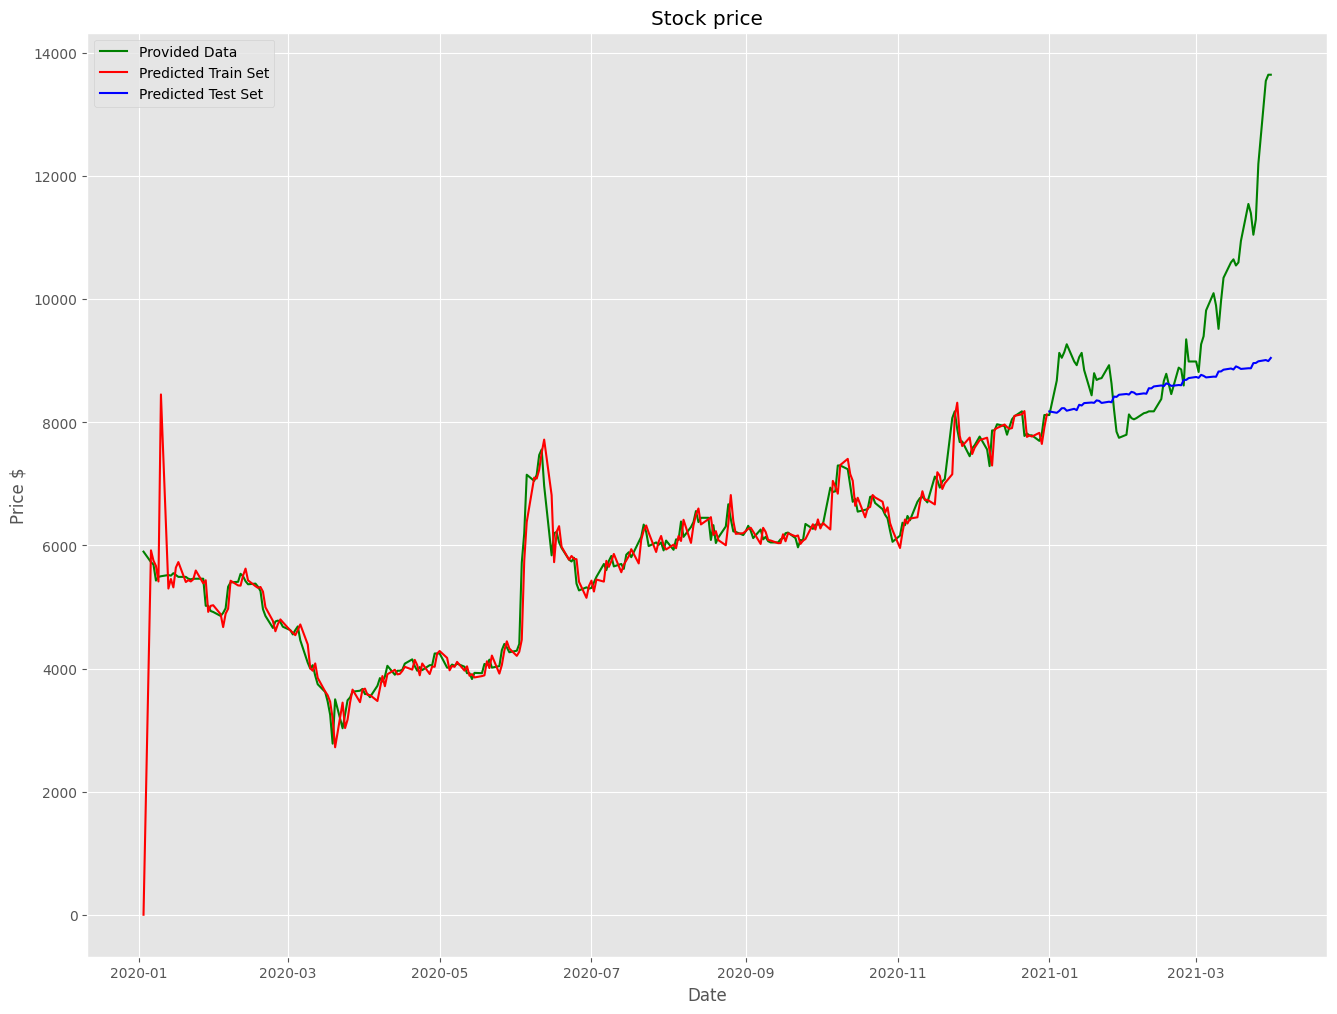

In [101]:
#plot of showing prediced data Vs. Actual data

mpl.plot(C8, color = 'g', label = 'Provided Data')
mpl.plot(model.predict(), color = 'r', label = 'Predicted Train Set')

C_pred8.index = C_test8.index
mpl.plot(C_pred8, color = 'b', label = 'Predicted Test Set')
mpl.xlabel('Date')
mpl.ylabel('Price $')
mpl.title('Stock price')
mpl.legend()
mpl.show()

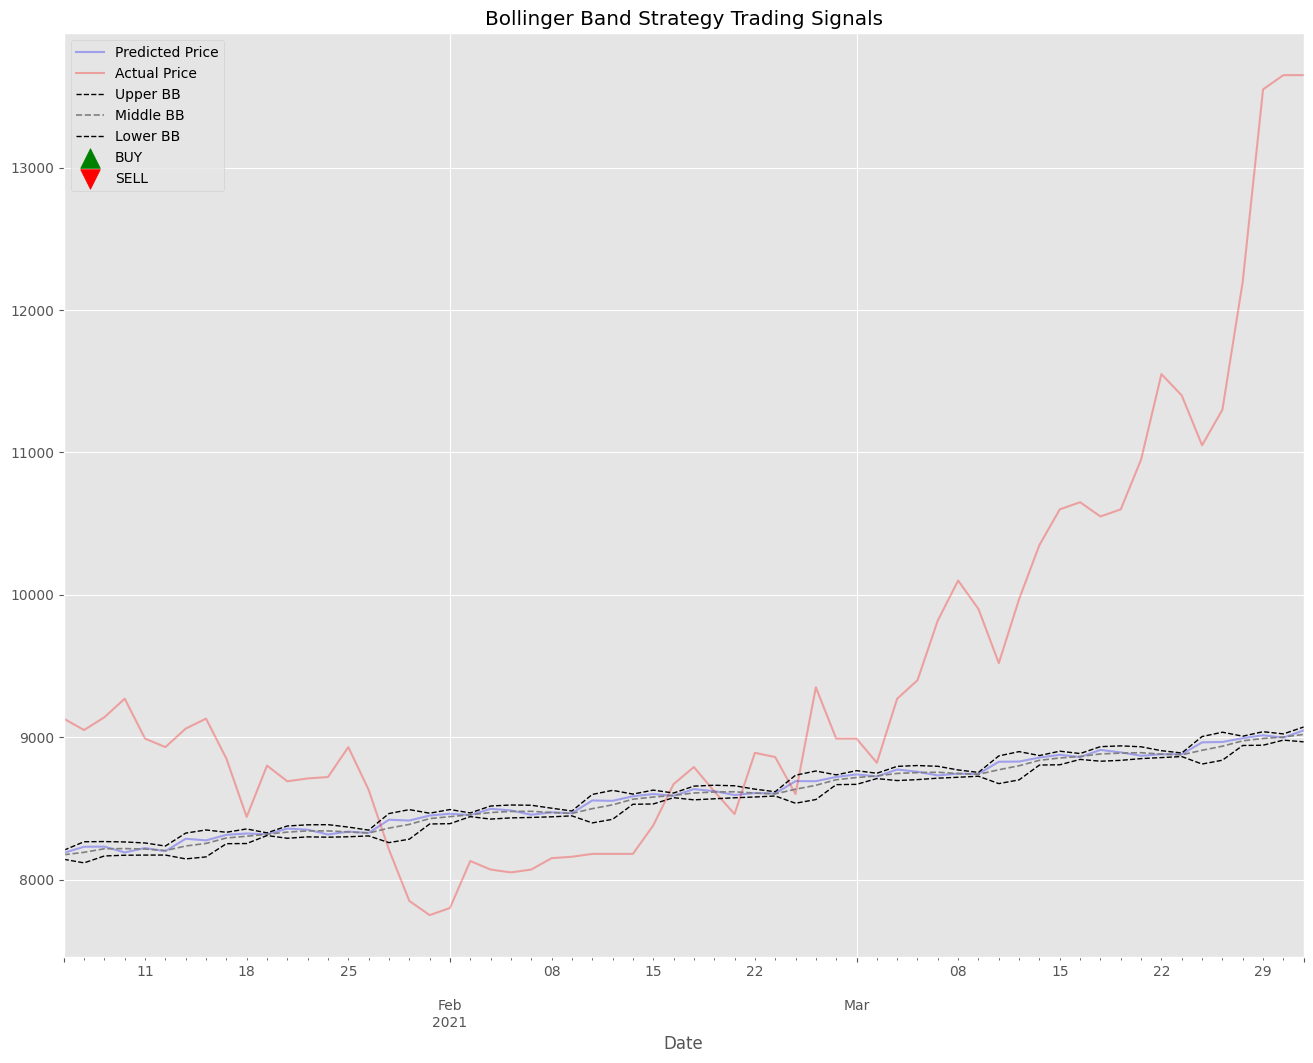

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 68.1%


In [102]:
df_pred8 = pd.DataFrame({'test_set':C_test8, 'predicted':C_pred8})
df_pred8 = bollinger_bands(df_pred8, 3)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred8['predicted'], df_pred8['lower'], df_pred8['upper'])
plot_bollinger(df_pred8, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test8)

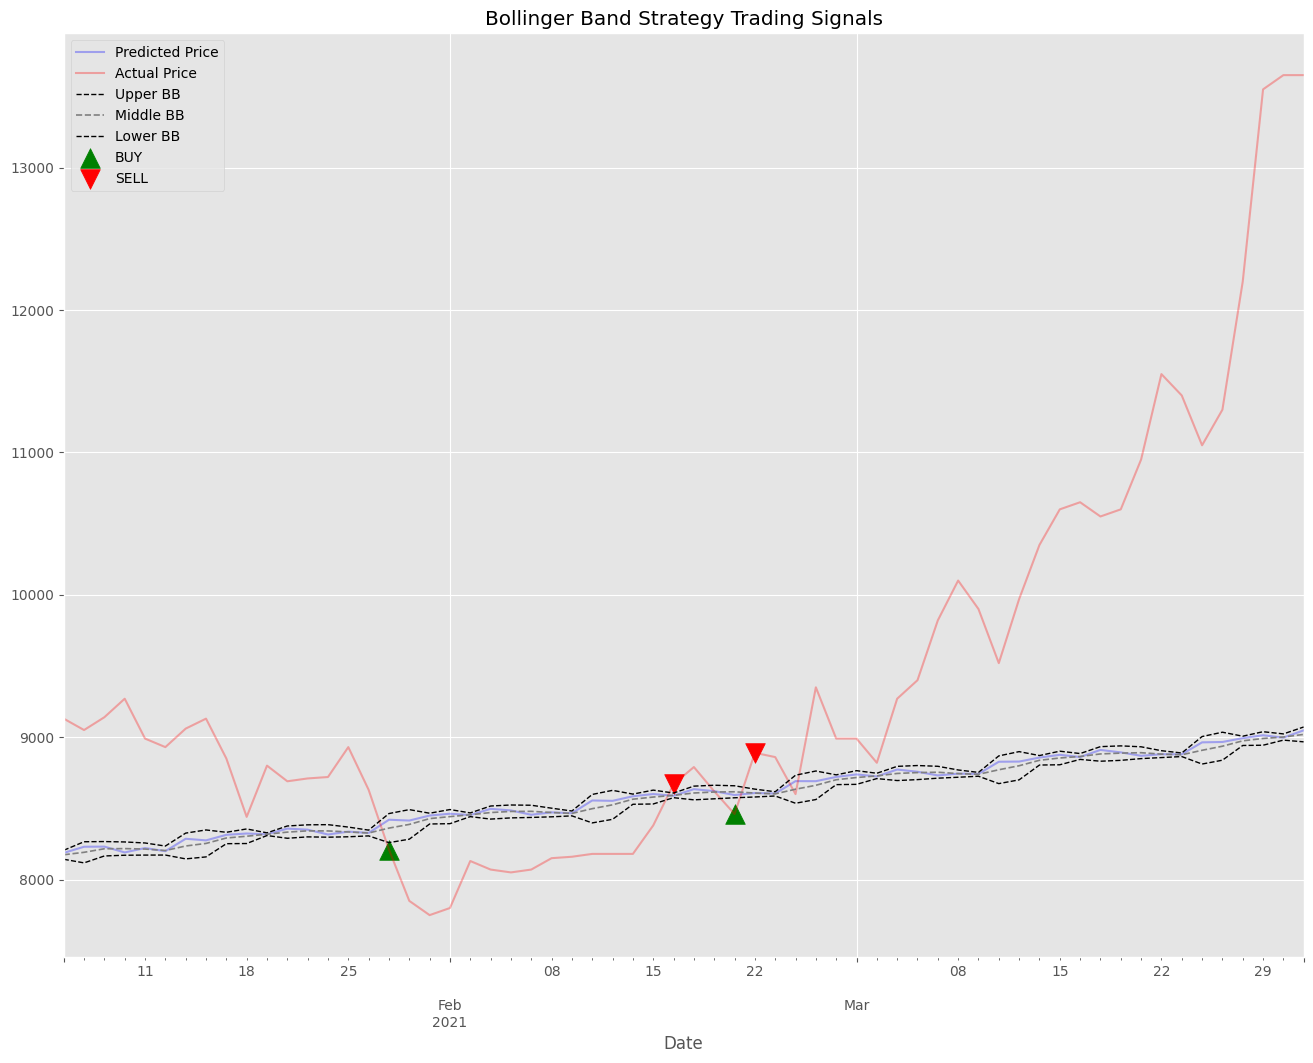

Return using Bollinger Band Strategy is 10.84%.
Return from do nothing strategy is 68.1%


In [103]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred8['test_set'], df_pred8['lower'], df_pred8['upper'])
plot_bollinger(df_pred8, buy_price, sell_price)
calculate_return(buy_price, sell_price, C_test8)

# Conclusion

For this project, time series forecasting dataset was decomposed to analyze. SARIMAX and ARIMA model was used on each individual stocks. The model was trianed with training assigned dataset ( Q1-Q4 in 2020) amd predicted with Q1 2021 dataset.

The prediction was tested by applying bollinger band strategy, ML strategy was used to get return higher in comparison to buy,sell and hold strategy

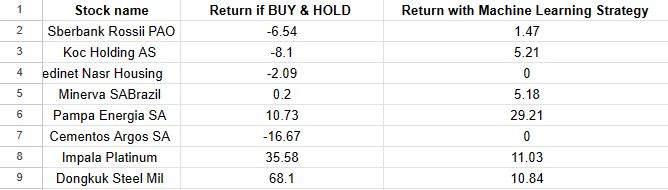



